In [12]:
import os
import math
import torch
import bitsandbytes as bnb
import torch.nn as nn
from safetensors.torch import load_file
import matplotlib.pyplot as plt


In [ ]:
@torch.no_grad()
def _get_mask_prune_magnitude(
    W,
    sparsity_ratio: float,
    prune_n: int,
    prune_m: int,
    largest: bool,
    offload: bool,
) -> torch.tensor:
    """
    get mask for pruning based on magnitude.
    largest: if True, prune the largest weights, otherwise prune the smallest weights.
    """
    W_metric = torch.abs(W)
    if prune_n != 0:
        W_mask = torch.zeros_like(W, dtype=torch.bool)
        for ii in range(W_metric.shape[1]):
            if ii % prune_m == 0:
                tmp = W_metric[:, ii : (ii + prune_m)].float()
                idx_to_keep = torch.topk(tmp, prune_n, dim=1, largest=largest)[1]
                W_mask.scatter_(1, ii + idx_to_keep, True)
    else:
        if largest:
            thresh = torch.sort(W_metric.flatten(), descending=True)[0][int(W.numel() * sparsity_ratio)].cpu()
            W_mask = W_metric >= thresh
        else:
            thresh = torch.sort(W_metric.flatten())[0][int(W.numel() * sparsity_ratio)].cpu()
            W_mask = W_metric < thresh
    if offload:
        return W_mask.cpu()
    else:
        return W_mask


In [ ]:
@torch.no_grad()
def decomposeW2LinearWeightLR(W: torch.Tensor, r: int):
    assert len(W.shape) == 2
    assert r in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

    M = W.to(dtype=torch.float32)
    U, S, Vh = torch.linalg.svd(M, full_matrices=False)

    # Extract the top r singular values and corresponding singular vectors:
    # U_r -> d x r matrix (top r left singular vectors)
    # S_r -> r singular values (top r)
    # Vh_r -> r x d matrix (top r right singular vectors transposed)
    U_r = U[:, :r]
    S_r = S[:r]
    Vh_r = Vh[:r, :]

    # Compute Sigma_r^(1/2) as a diagonal matrix with the square roots of S_r.
    # Since S_r contains nonnegative singular values, taking the square root works elementwise.
    sqrt_S_r = torch.sqrt(S_r)
    Sigma_r_half = torch.diag(sqrt_S_r)

    # Form the optimal factors:
    # X_opt = U_r * Sigma_r^(1/2)
    # Y_opt = Sigma_r^(1/2) * V_r^T. Note: V_r^T is given by Vh_r.
    R = U_r @ Sigma_r_half
    L = Sigma_r_half @ Vh_r

    return L.to(dtype=W.dtype), R.to(dtype=W.dtype)

In [ ]:
def draw(W):
    # abs_w = W.abs().view(-1).cpu().numpy()
    plt.figure(figsize=(6, 3))
    plt.hist(W.to(torch.float).view(-1).cpu().numpy(), bins=200, log=True, color="#1f77b4")
    plt.title("Histogram of |W| with 0.05% extreme outliers")
    plt.xlabel("|w|")
    plt.ylabel("log10(count)")
    plt.tight_layout()

    save_path = "hist_outliers.png"
    plt.savefig(save_path, dpi=200)
    print(f"Figure saved to: {os.path.abspath(save_path)}")

def relativeError(a: torch.Tensor, b: torch.Tensor):
    return torch.norm(a - b, p="fro") / torch.norm(a, p="fro")

In [23]:
def check_outlier_restore(weight, sparsity_ratio=0.00005):
    in_d = weight.shape[1]
    out_d = weight.shape[0]
    
    compute_dtype = torch.bfloat16
    linear = torch.nn.Linear(in_d, out_d, bias=False, dtype=compute_dtype).to("cuda")
    linear.requires_grad_(False)
    device = linear.weight.device
    linear.weight.copy_(weight.to(compute_dtype).contiguous())
    
    # draw the weight before pruning
    draw(linear.weight.data)
    
    x = torch.randn(4096,in_d, dtype=compute_dtype).to("cuda")
    golden_output = linear(x)

    # quantize the weight
    weight_bf16 = linear.weight.detach().to(compute_dtype).contiguous()
    bias = None if linear.bias is None else linear.bias.detach().clone()

    qlinear = bnb.nn.Linear4bit(
        in_d,
        out_d,
        bias=bias is not None,
        compute_dtype=compute_dtype,
        quant_type="fp4",
    ).to(device)

    qlinear.weight = bnb.nn.Params4bit(
        weight_bf16,
        requires_grad=False,
        quant_type="fp4",
    ).to(device)
    if bias is not None:
        qlinear.bias = nn.Parameter(bias)

    quantized_output = qlinear(x)
    
    # prune the weight (only the largest 0.00005% weights for outlier restoration)
    sparse_mask = _get_mask_prune_magnitude(weight_bf16, sparsity_ratio=sparsity_ratio, prune_n=0, prune_m=0, largest=True, offload=False)
    print(sparse_mask.sum().item(), "sparse_mask sum")
    tmp_W = linear.weight.detach().to(compute_dtype).contiguous()
    linear.weight.data[sparse_mask.cuda()] = 0
    tmp_W = tmp_W - linear.weight.data
    WL, WR = decomposeW2LinearWeightLR(
                tmp_W,
                16,
            )
    WL_linear = nn.Linear(WL.shape[1], WL.shape[0], bias=False, dtype=compute_dtype).to(device)
    WL_linear.weight.data.copy_(WL)
    WR_linear = nn.Linear(WR.shape[1], WR.shape[0], bias=False, dtype=compute_dtype).to(device)
    WR_linear.weight.data.copy_(WR)
    sparse_weight_bf16 = linear.weight.detach().to(compute_dtype).contiguous()
    
    # draw the weight after pruning
    # draw(linear.weight.data)
    
    qlinear_wo_outlier = bnb.nn.Linear4bit(
        in_d,
        out_d,
        bias=bias is not None,
        compute_dtype=compute_dtype,
        quant_type="nf4",
    ).to(device)

    qlinear_wo_outlier.weight = bnb.nn.Params4bit(
        sparse_weight_bf16,
        requires_grad=False,
        quant_type="nf4",
    ).to(device)

    quantized_output_wo_outlier = qlinear_wo_outlier(x) + WR_linear(WL_linear(x))
    
    relativeError_value = relativeError(golden_output, quantized_output)
    relativeError_value_wo_outlier = relativeError(golden_output, quantized_output_wo_outlier)

    return relativeError_value, relativeError_value_wo_outlier

Estimated σ = 0.0167
Optimal u* = 3.2258
Prune threshold t* = σ·u* = 0.0538
Optimal sparsity ρ* = 0.126%
Figure saved to: /mnt/sdb/zhanglongteng/workspace/llm-toolkit/tmp/check_outlier_restore/hist_outliers.png
46 sparse_mask sum
Relative error for model.layers.0.mlp.down_proj.weight: 0.1240234375 (with outliers), 0.09521484375 (without outliers)
Estimated σ = 0.0163
Optimal u* = 3.2258
Prune threshold t* = σ·u* = 0.0525
Optimal sparsity ρ* = 0.126%
Figure saved to: /mnt/sdb/zhanglongteng/workspace/llm-toolkit/tmp/check_outlier_restore/hist_outliers.png
47 sparse_mask sum
Relative error for model.layers.0.mlp.gate_proj.weight: 0.12255859375 (with outliers), 0.095703125 (without outliers)
Estimated σ = 0.0160
Optimal u* = 3.2258
Prune threshold t* = σ·u* = 0.0516
Optimal sparsity ρ* = 0.126%
Figure saved to: /mnt/sdb/zhanglongteng/workspace/llm-toolkit/tmp/check_outlier_restore/hist_outliers.png
47 sparse_mask sum
Relative error for model.layers.0.mlp.up_proj.weight: 0.12255859375 (with

/tmp/ipykernel_1673265/2230803599.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 3))


Figure saved to: /mnt/sdb/zhanglongteng/workspace/llm-toolkit/tmp/check_outlier_restore/hist_outliers.png
18 sparse_mask sum
Relative error for model.layers.10.self_attn.v_proj.weight: 0.1220703125 (with outliers), 0.09326171875 (without outliers)
Estimated σ = 0.0178
Optimal u* = 3.2258
Prune threshold t* = σ·u* = 0.0574
Optimal sparsity ρ* = 0.126%
Figure saved to: /mnt/sdb/zhanglongteng/workspace/llm-toolkit/tmp/check_outlier_restore/hist_outliers.png
46 sparse_mask sum
Relative error for model.layers.11.mlp.down_proj.weight: 0.123046875 (with outliers), 0.0947265625 (without outliers)
Estimated σ = 0.0190
Optimal u* = 3.2258
Prune threshold t* = σ·u* = 0.0614
Optimal sparsity ρ* = 0.126%
Figure saved to: /mnt/sdb/zhanglongteng/workspace/llm-toolkit/tmp/check_outlier_restore/hist_outliers.png
46 sparse_mask sum
Relative error for model.layers.11.mlp.gate_proj.weight: 0.12255859375 (with outliers), 0.0927734375 (without outliers)
Estimated σ = 0.0180
Optimal u* = 3.2258
Prune thresho

OutOfMemoryError: CUDA out of memory. Tried to allocate 562.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 256.38 MiB is free. Including non-PyTorch memory, this process has 47.27 GiB memory in use. Of the allocated memory 44.38 GiB is allocated by PyTorch, and 2.54 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

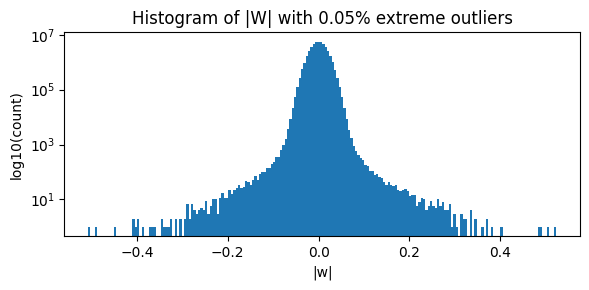

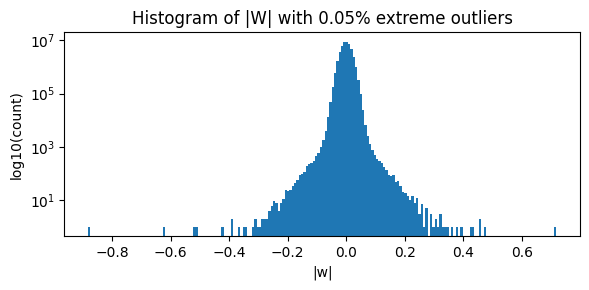

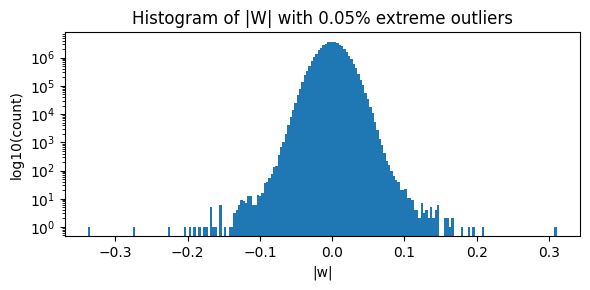

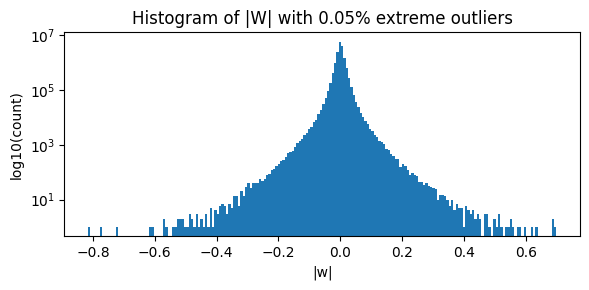

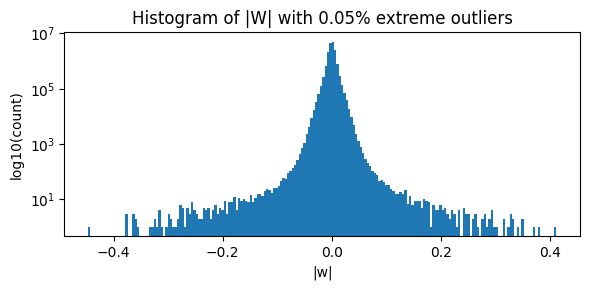

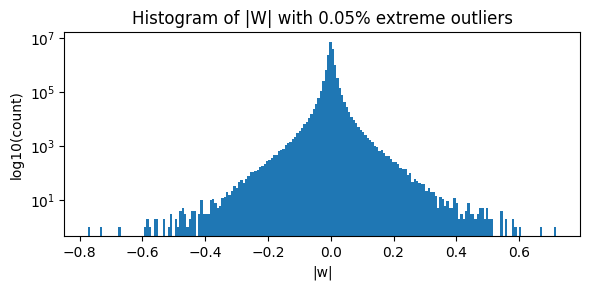

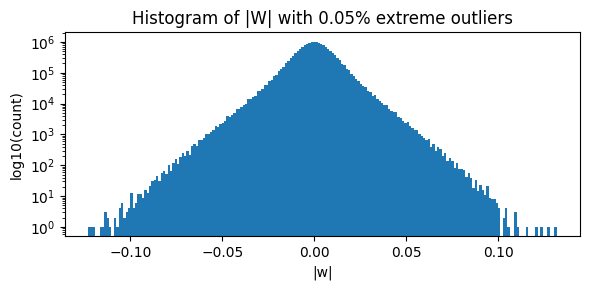

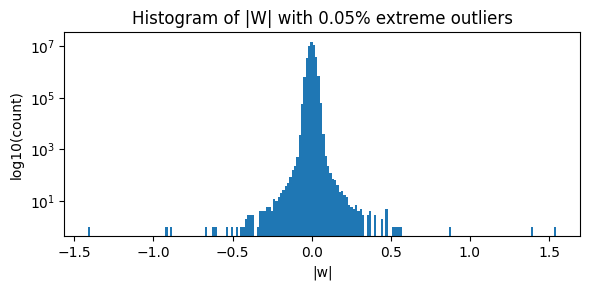

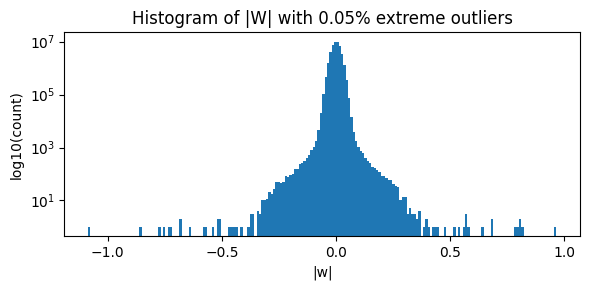

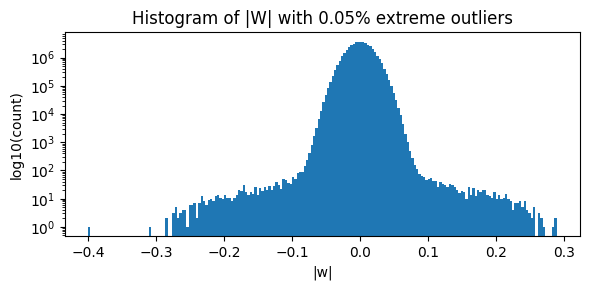

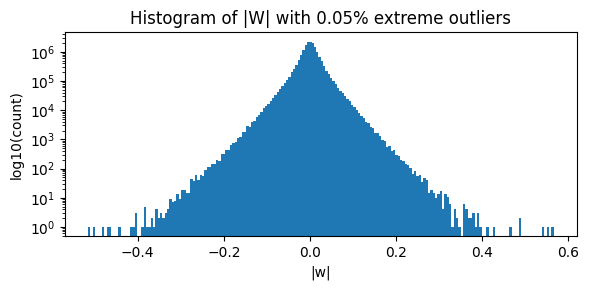

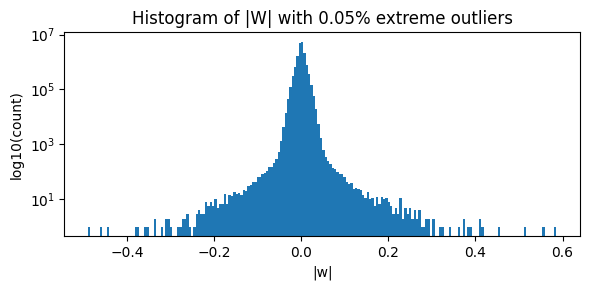

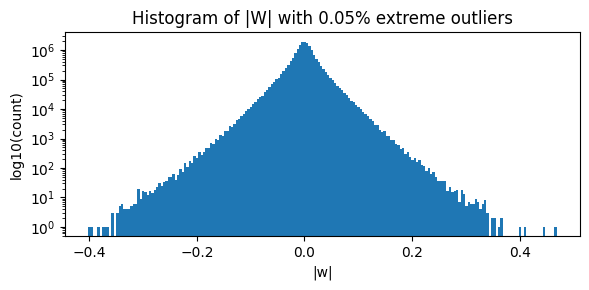

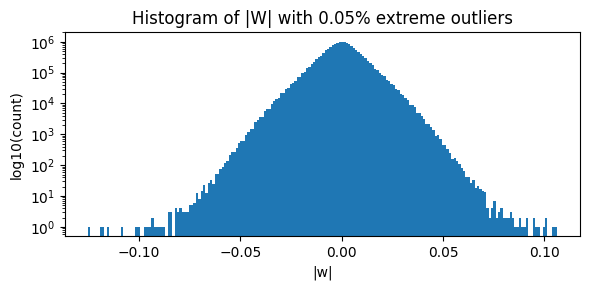

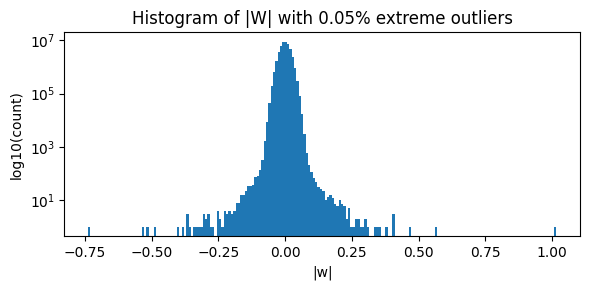

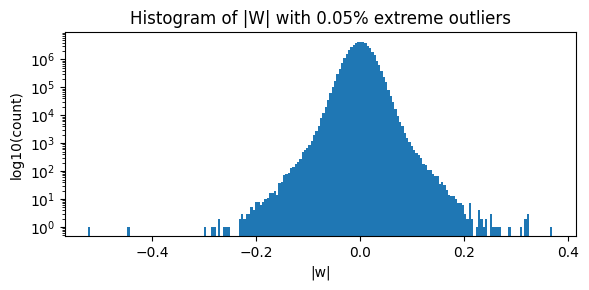

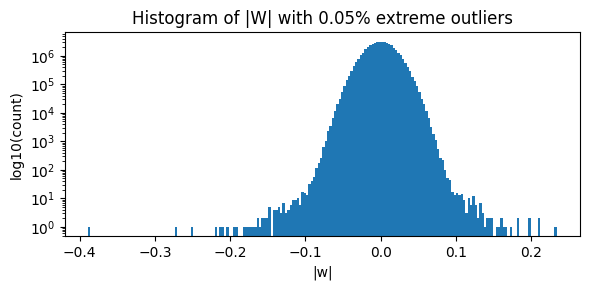

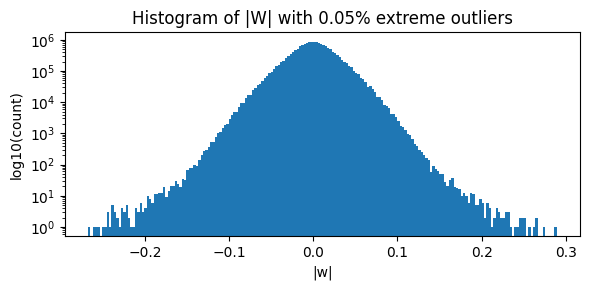

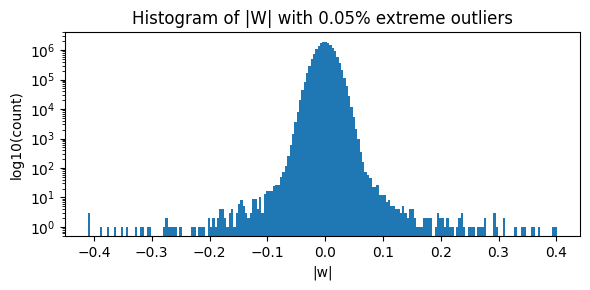

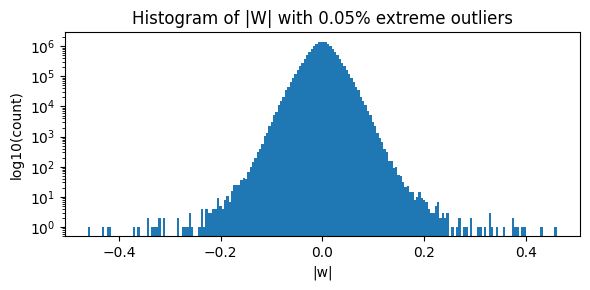

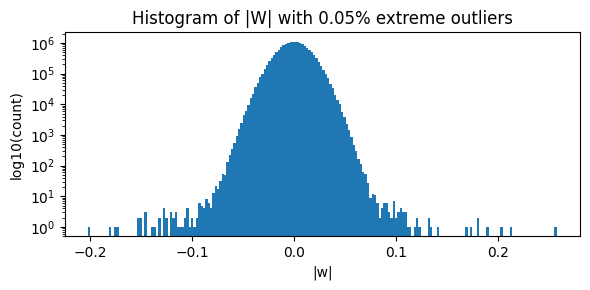

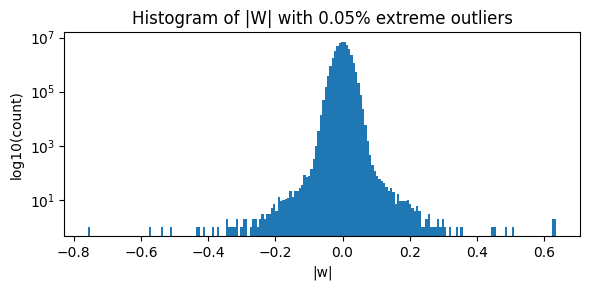

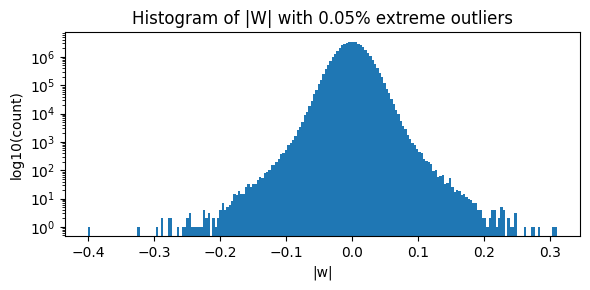

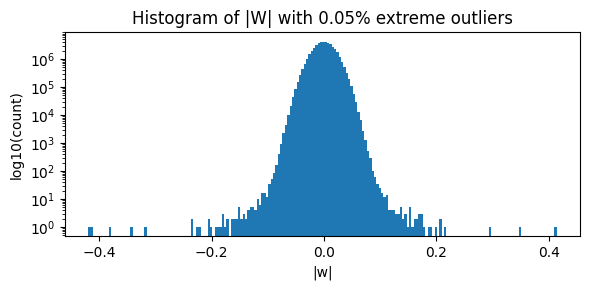

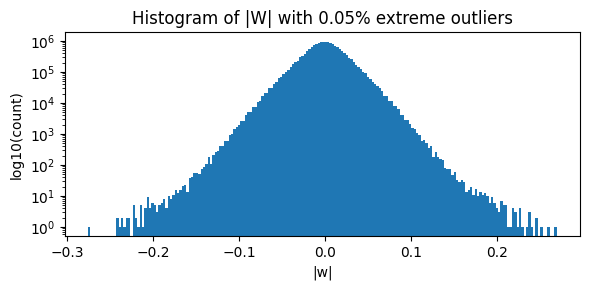

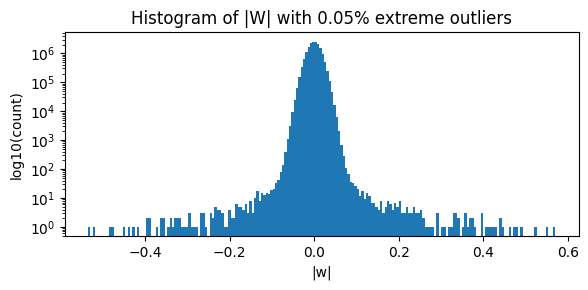

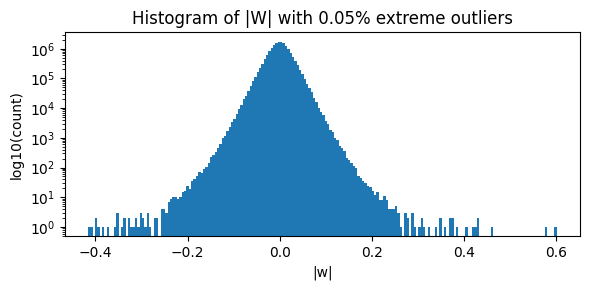

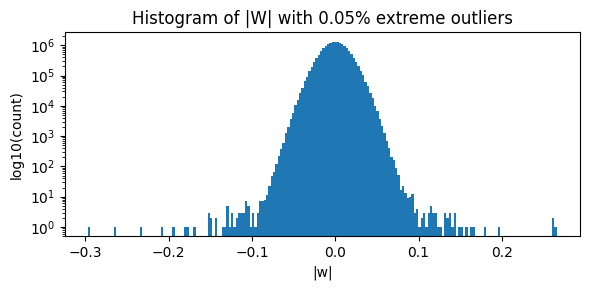

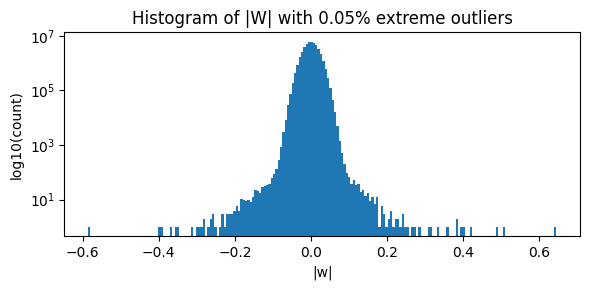

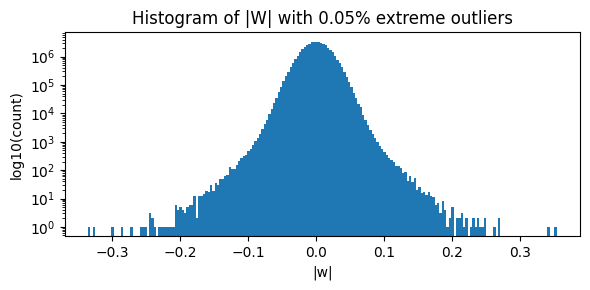

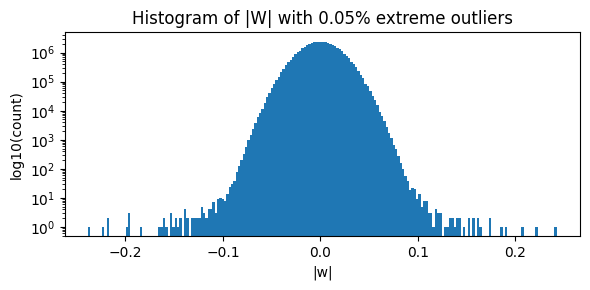

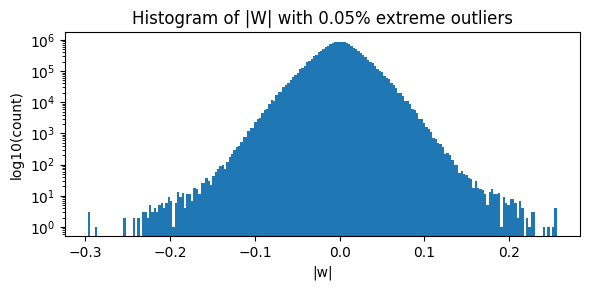

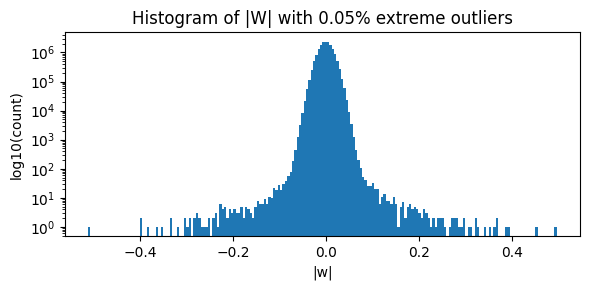

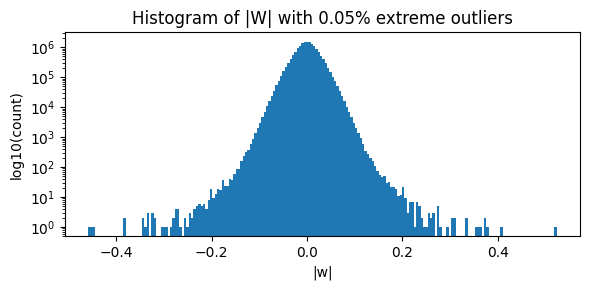

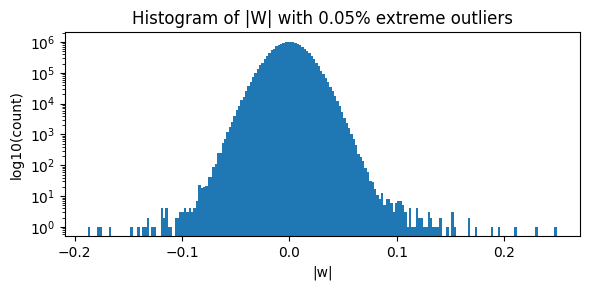

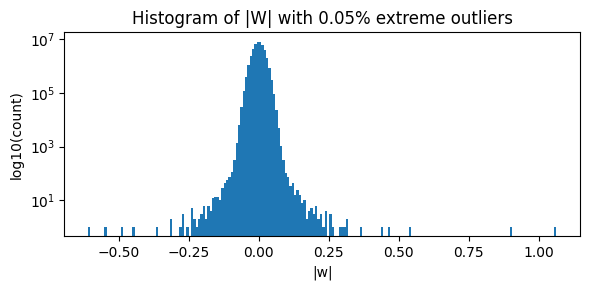

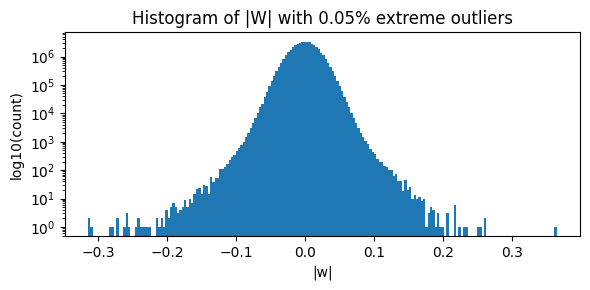

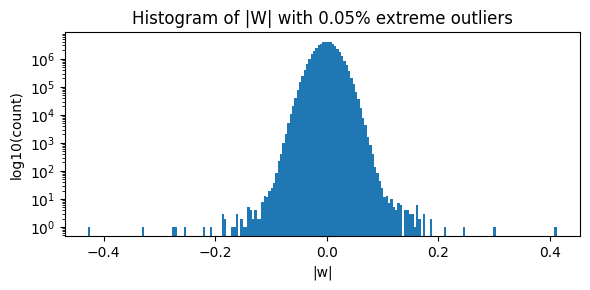

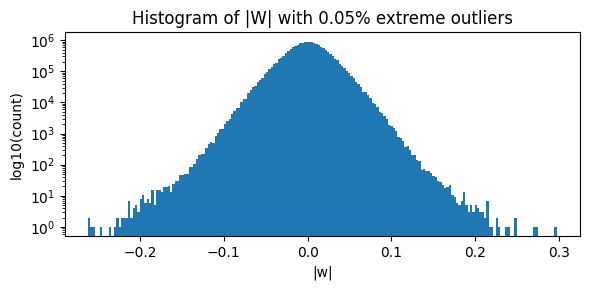

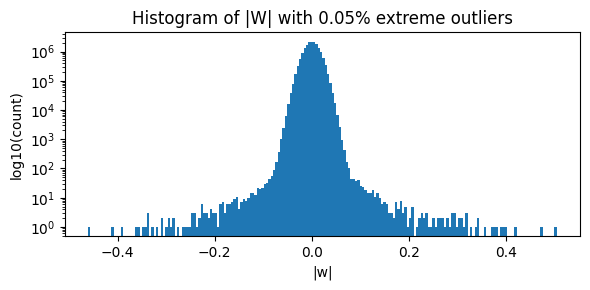

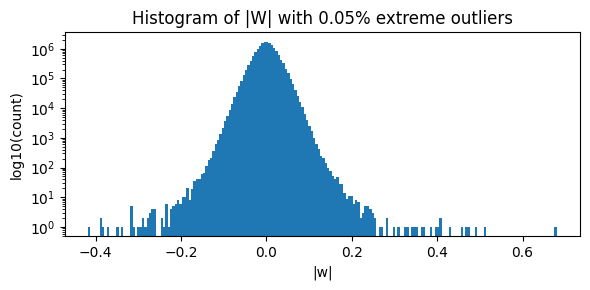

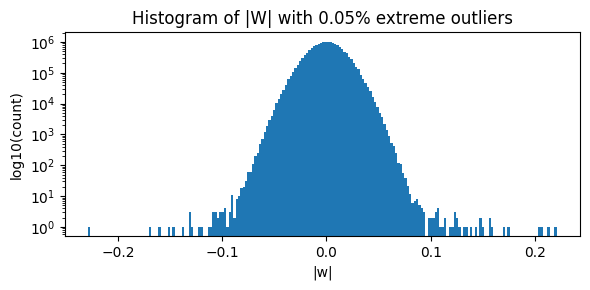

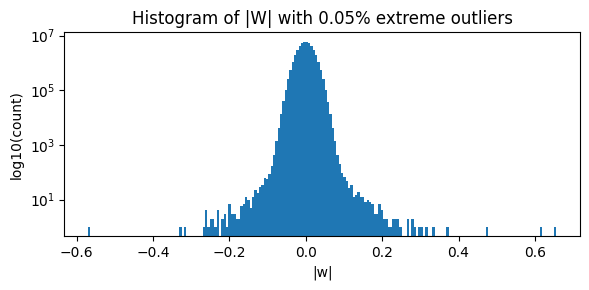

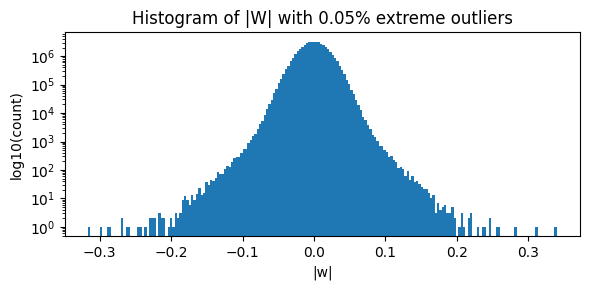

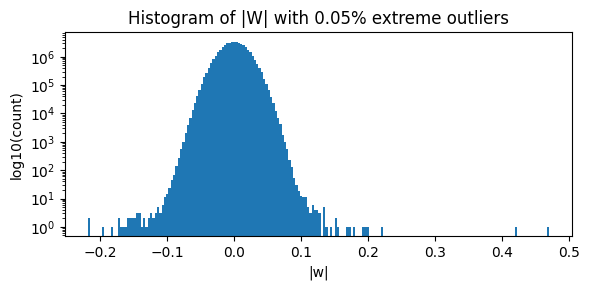

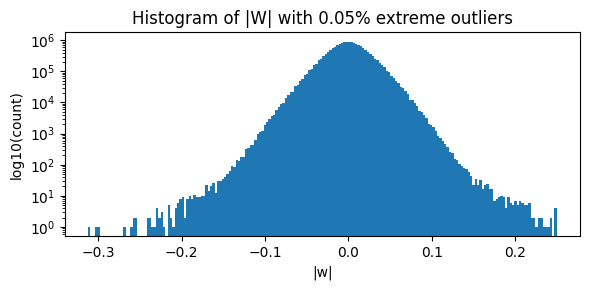

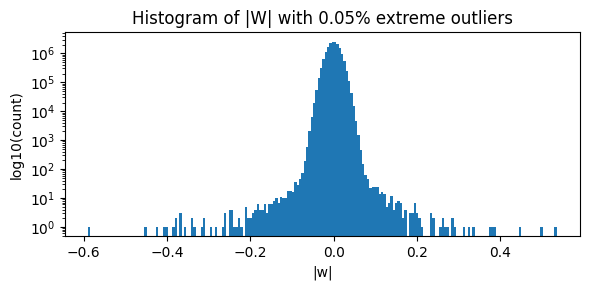

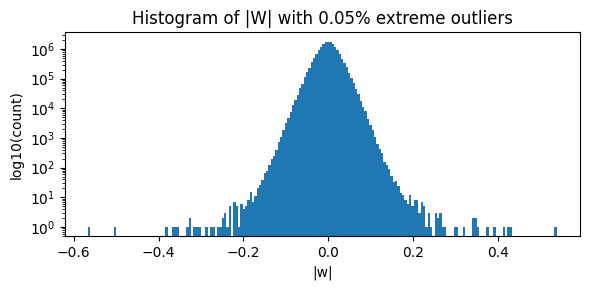

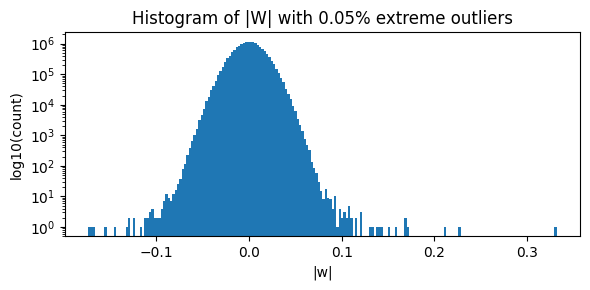

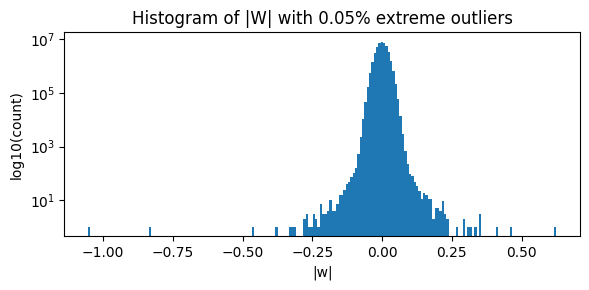

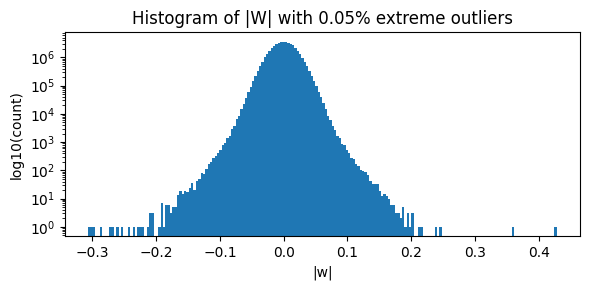

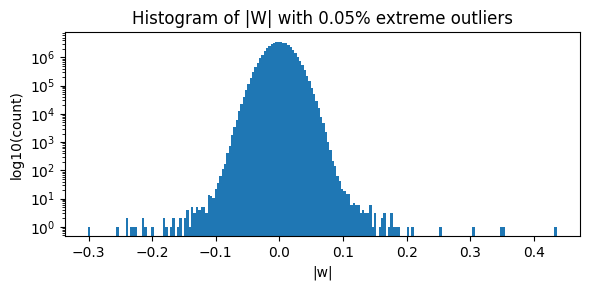

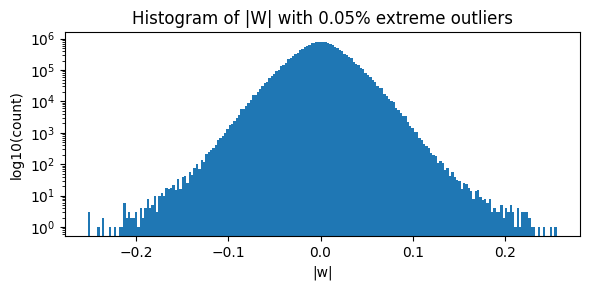

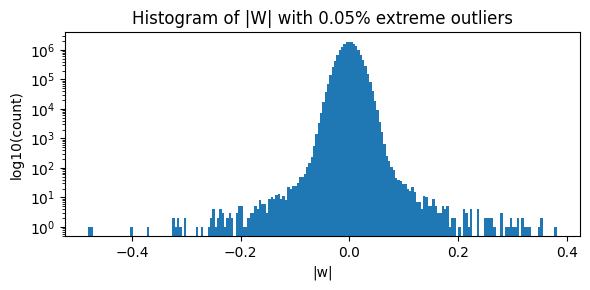

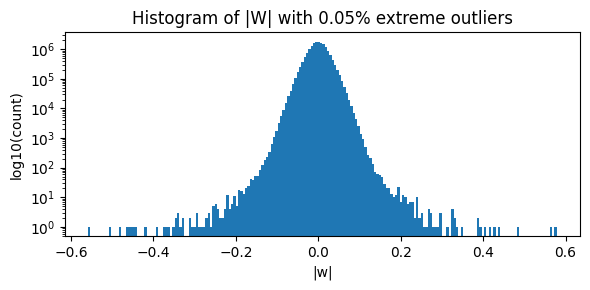

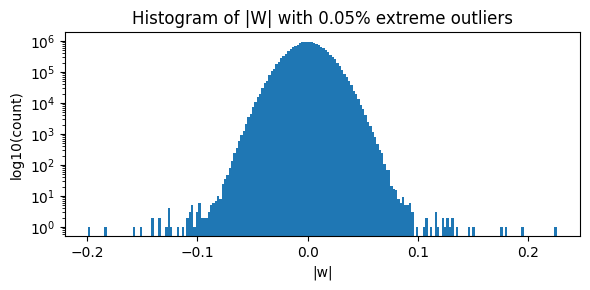

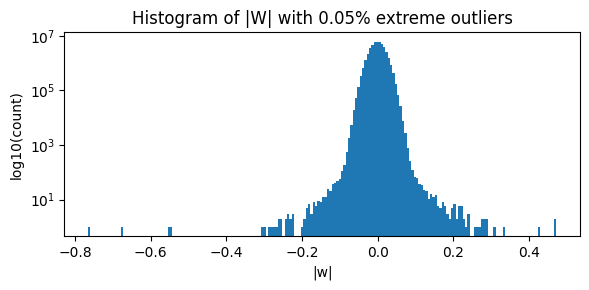

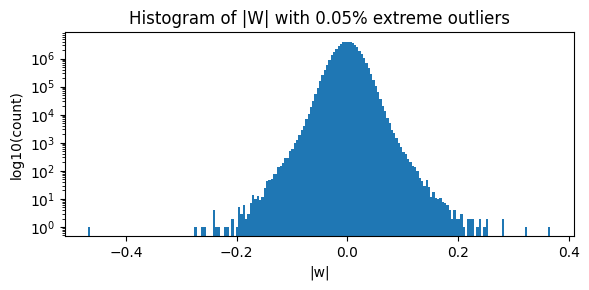

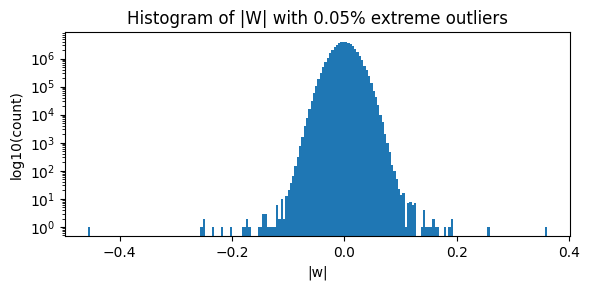

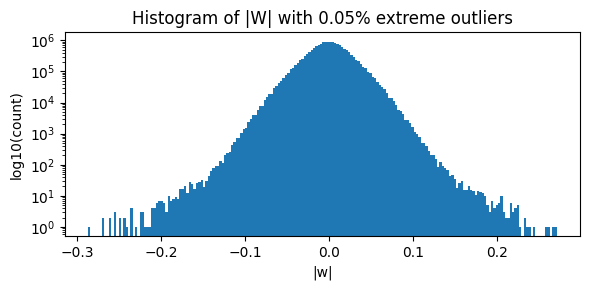

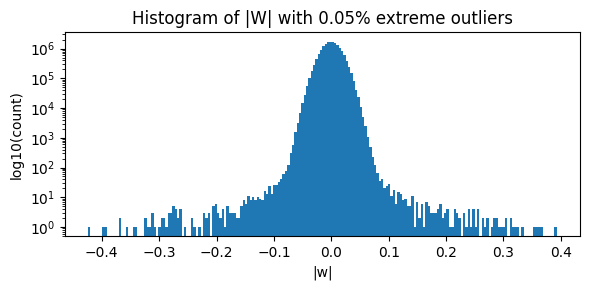

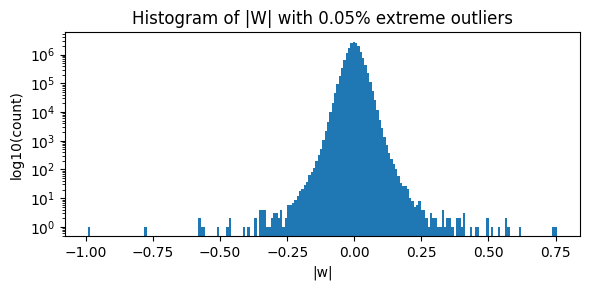

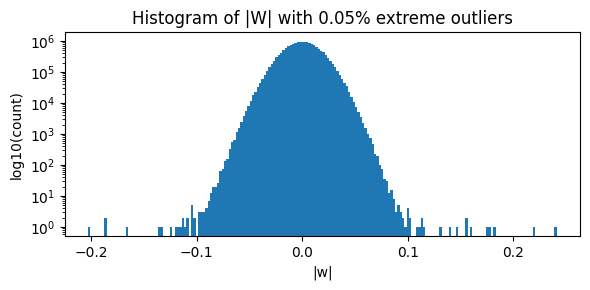

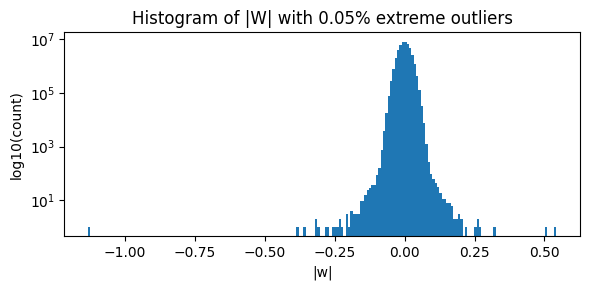

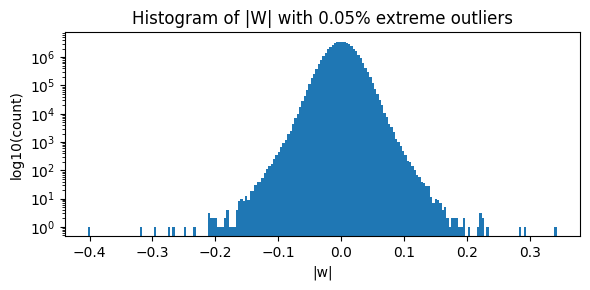

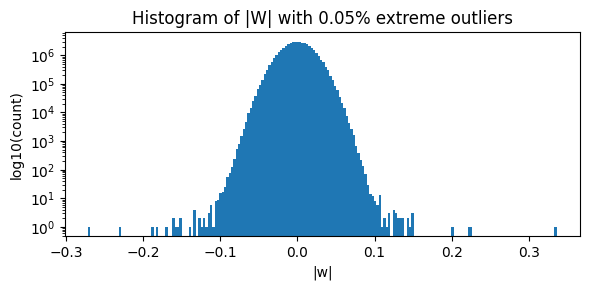

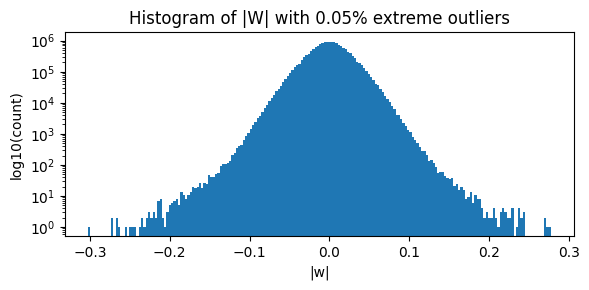

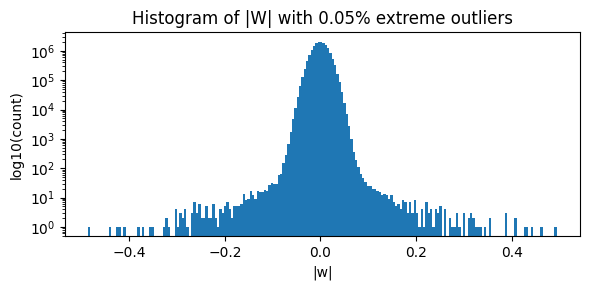

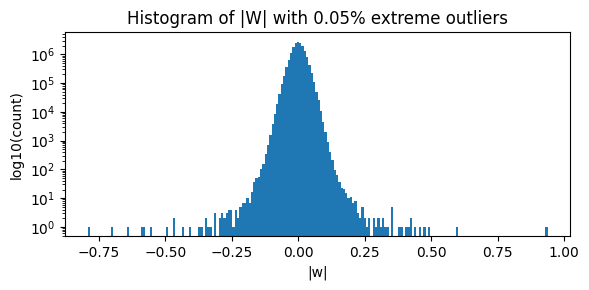

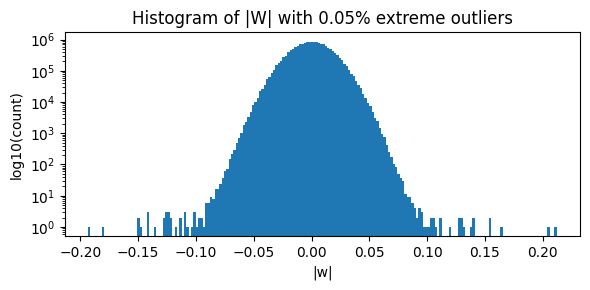

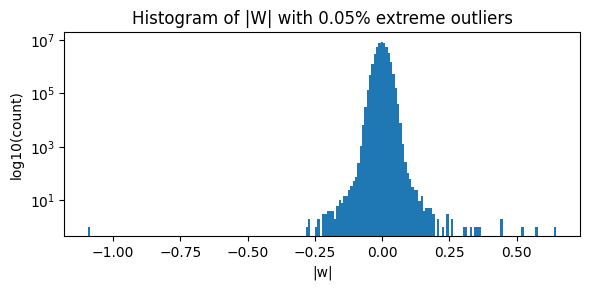

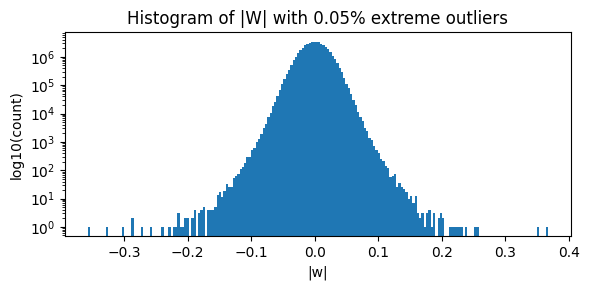

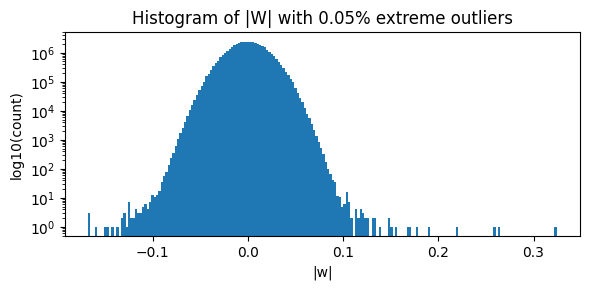

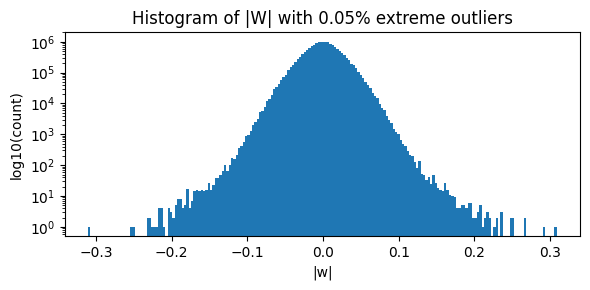

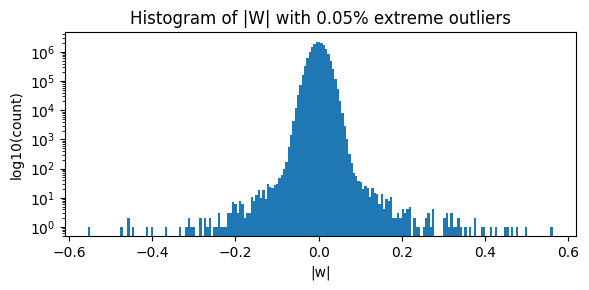

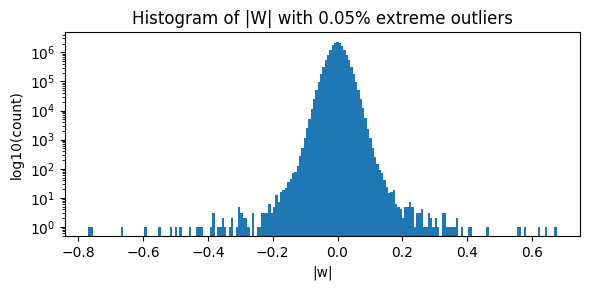

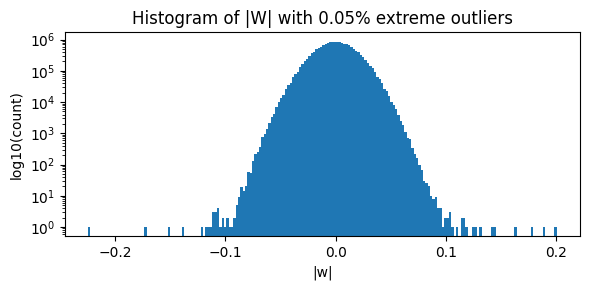

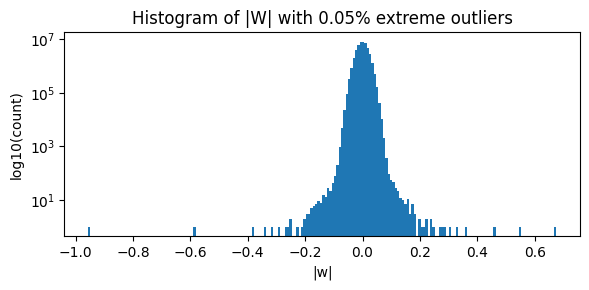

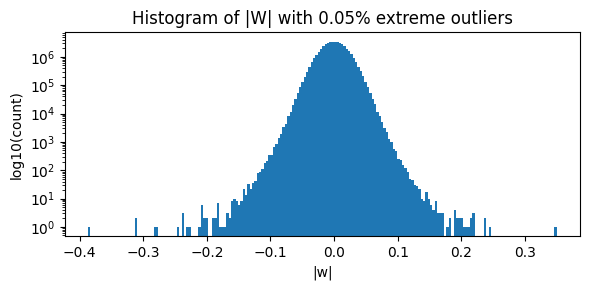

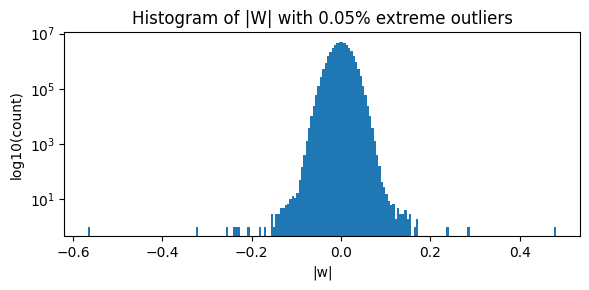

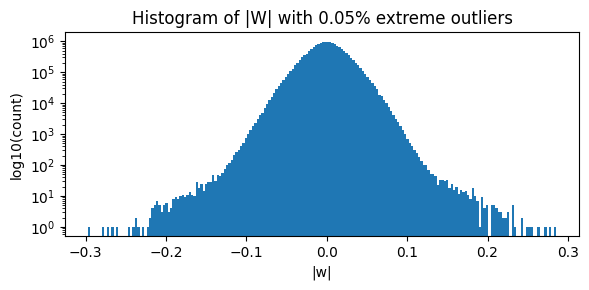

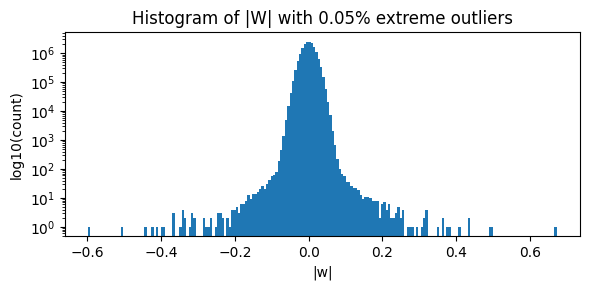

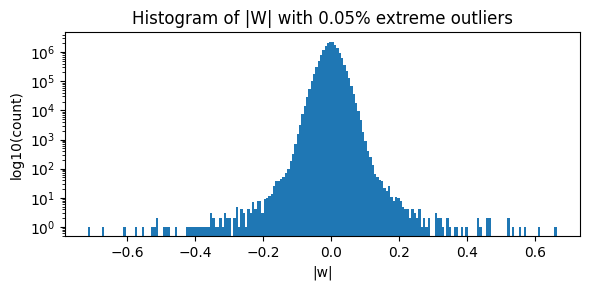

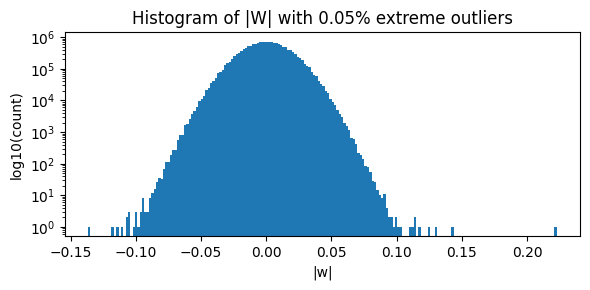

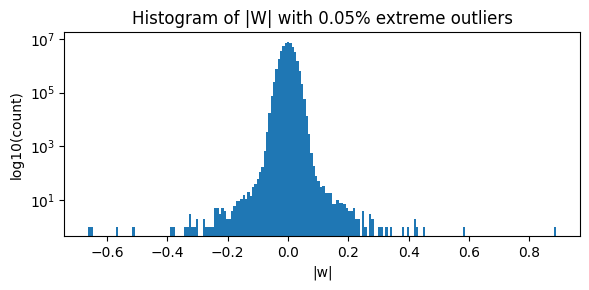

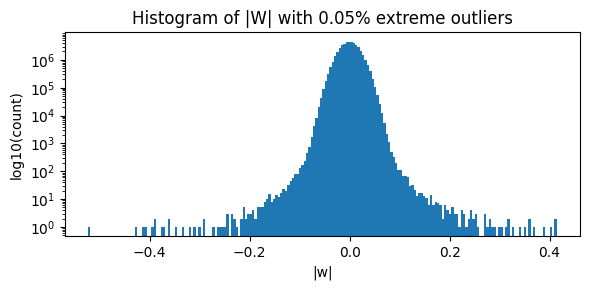

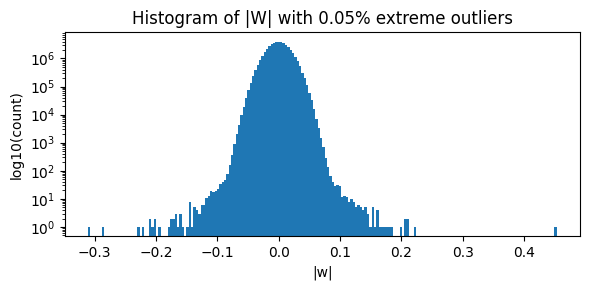

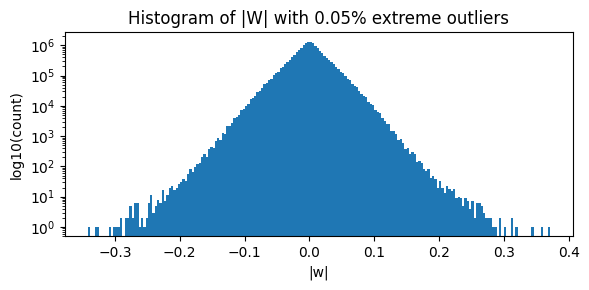

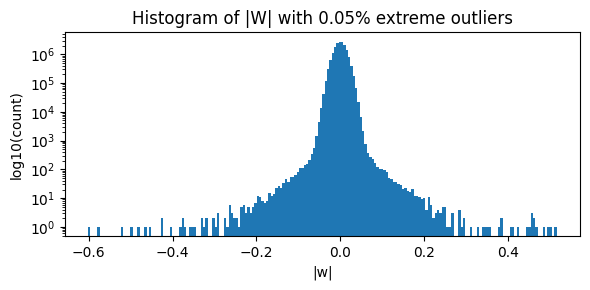

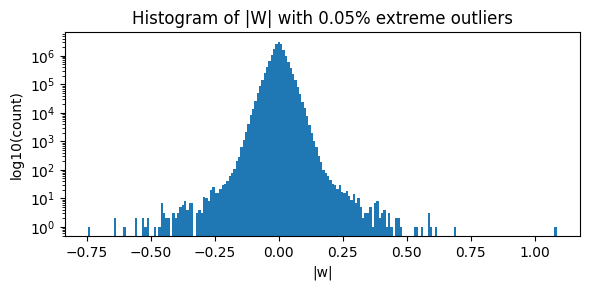

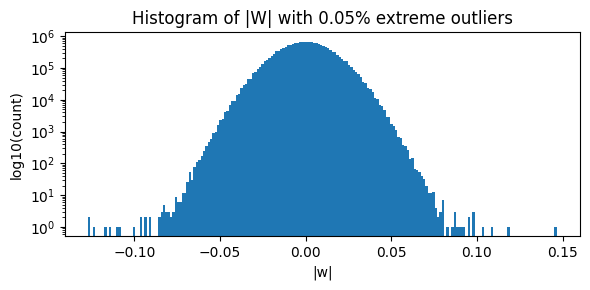

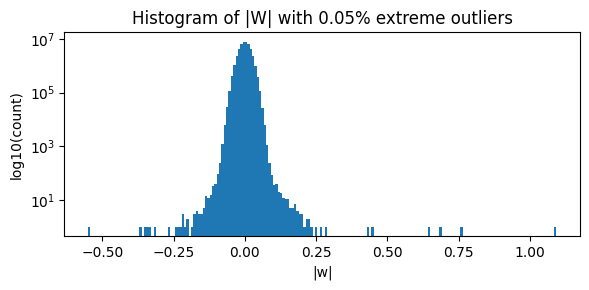

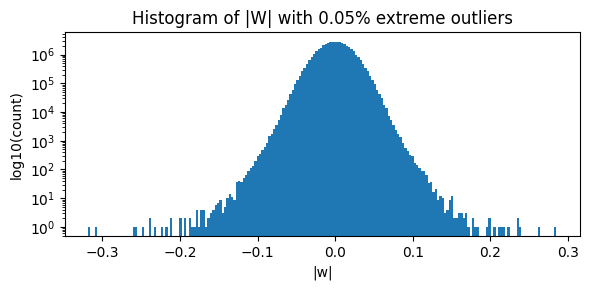

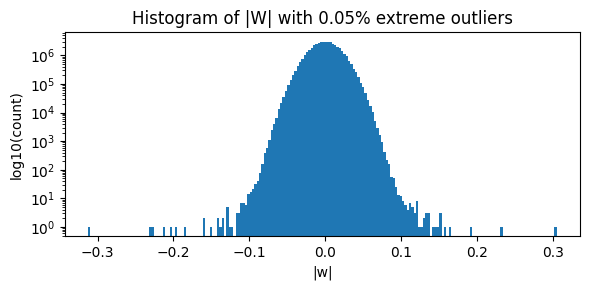

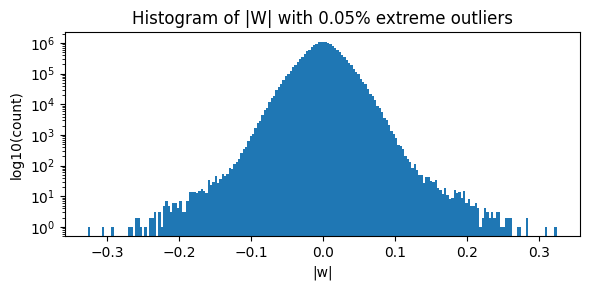

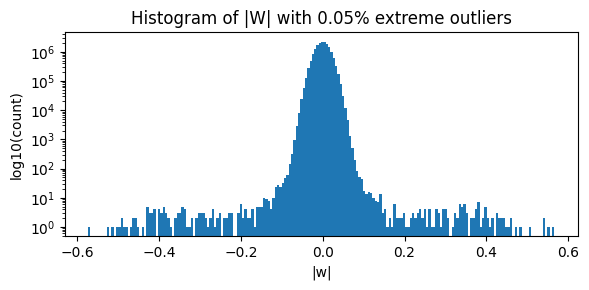

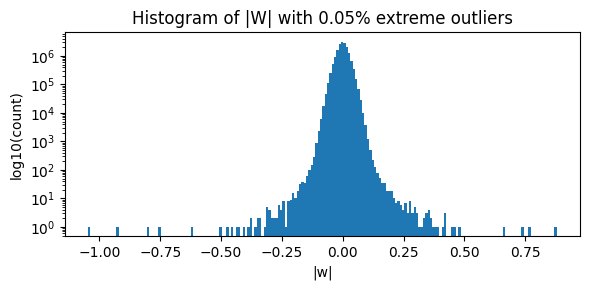

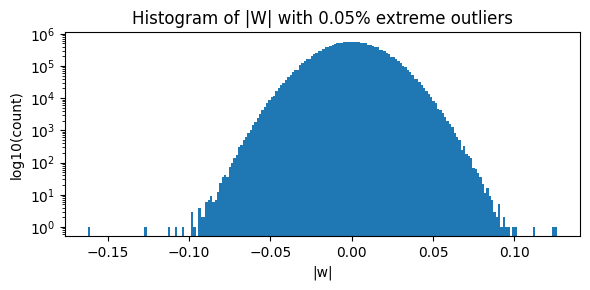

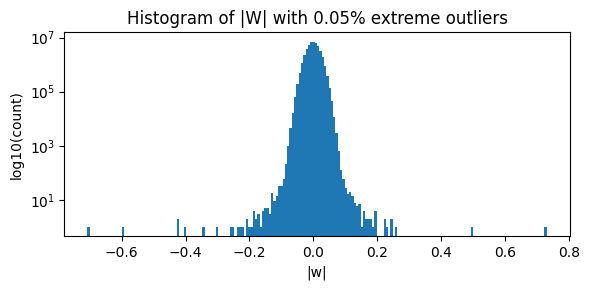

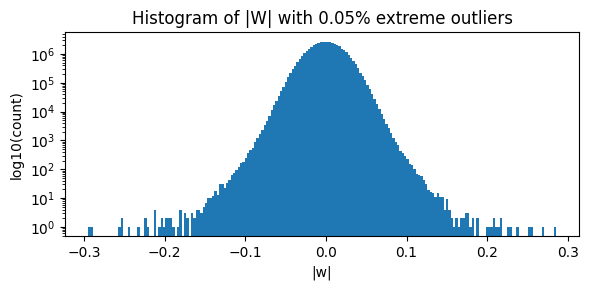

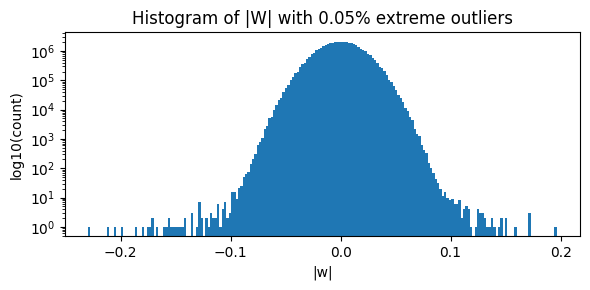

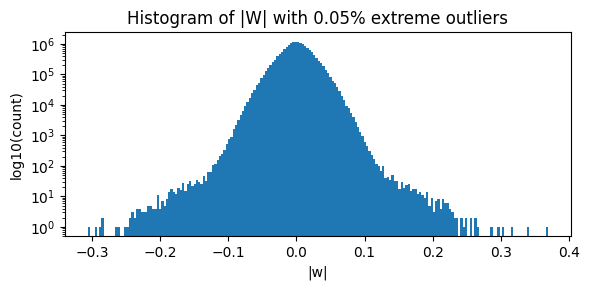

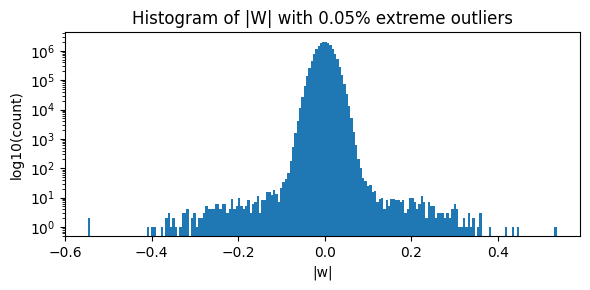

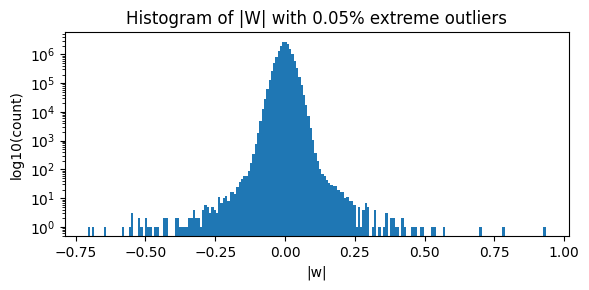

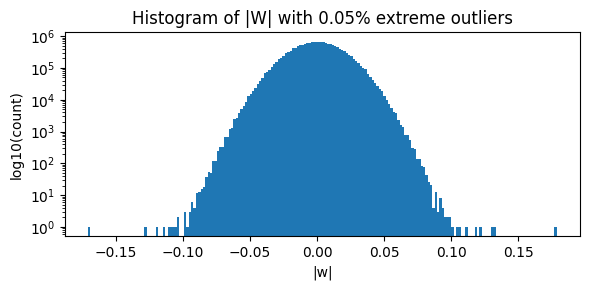

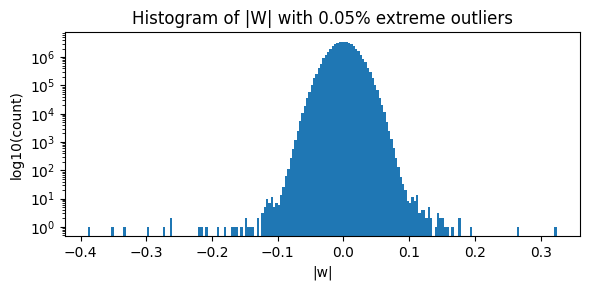

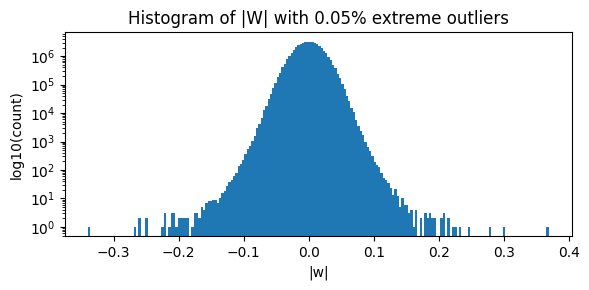

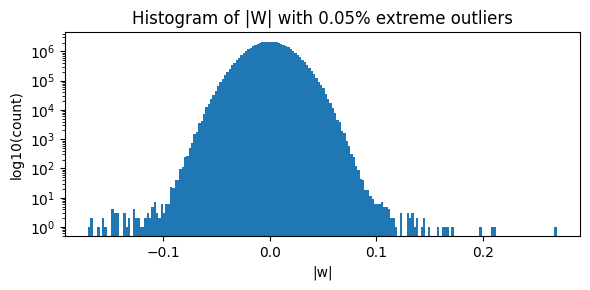

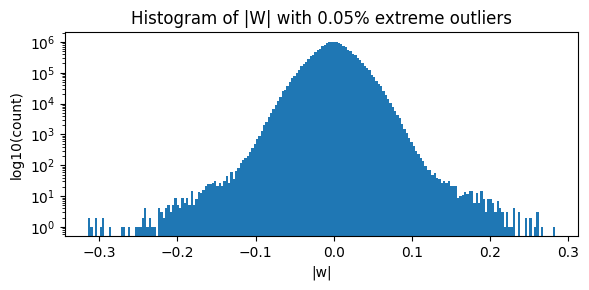

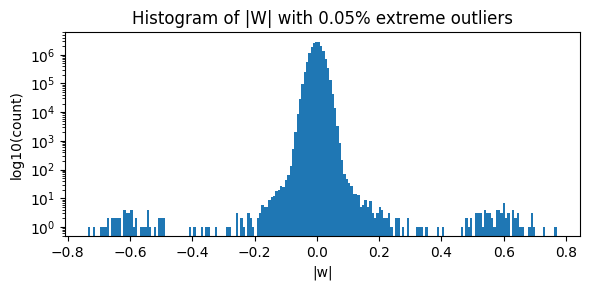

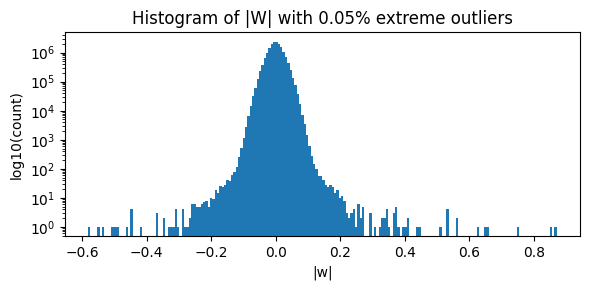

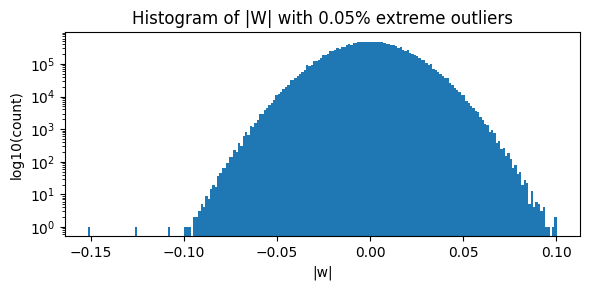

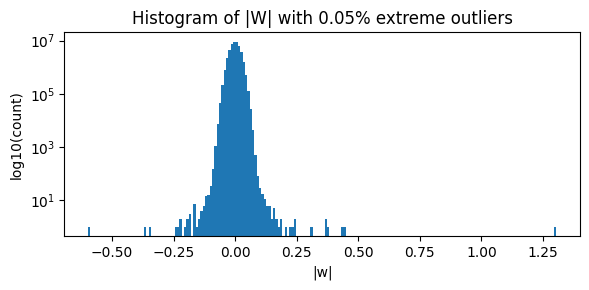

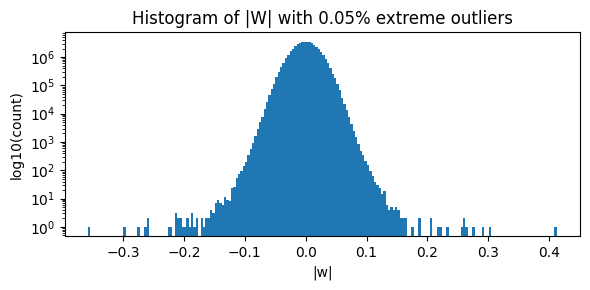

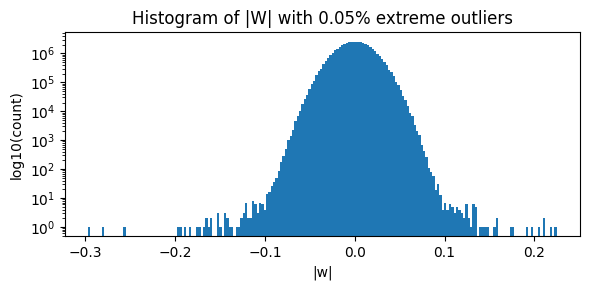

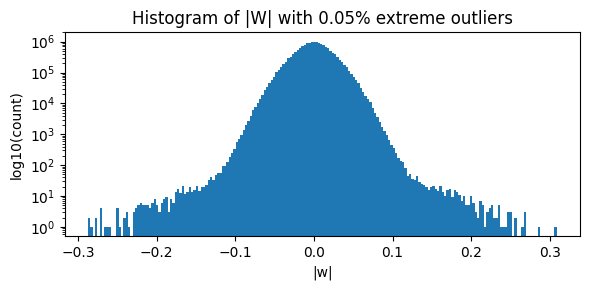

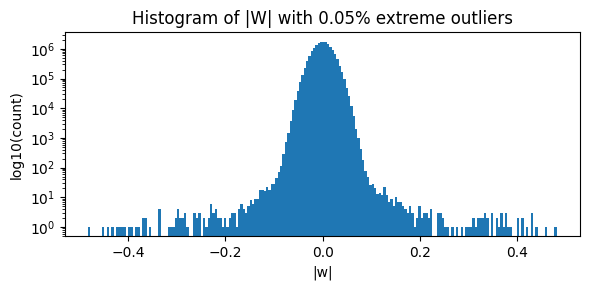

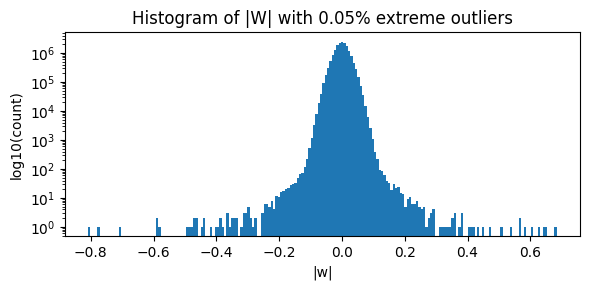

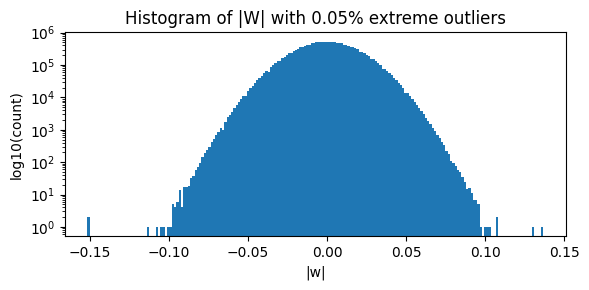

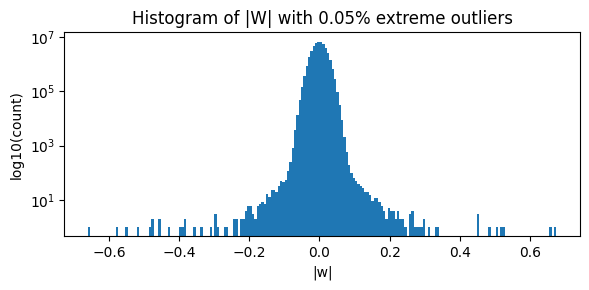

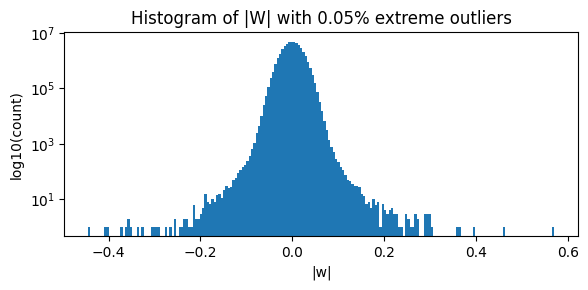

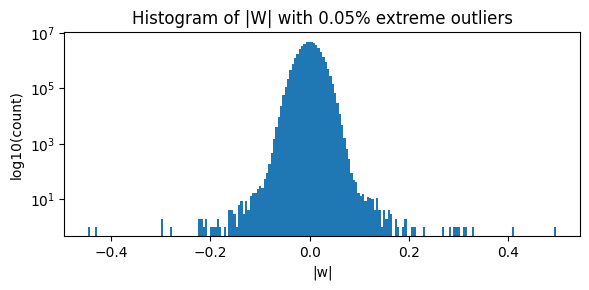

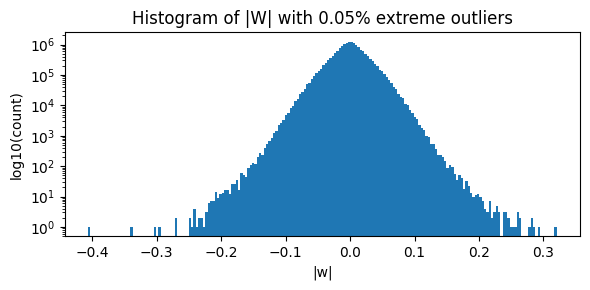

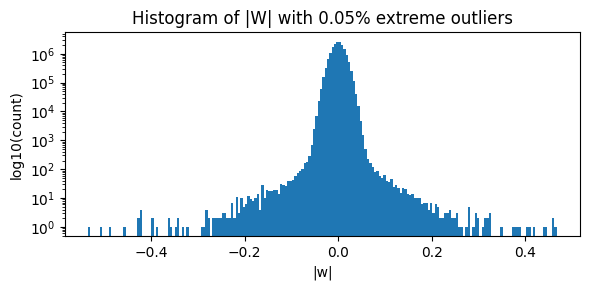

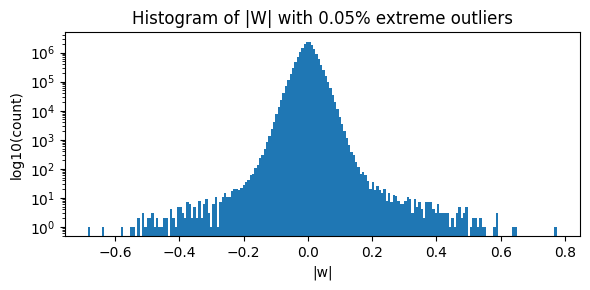

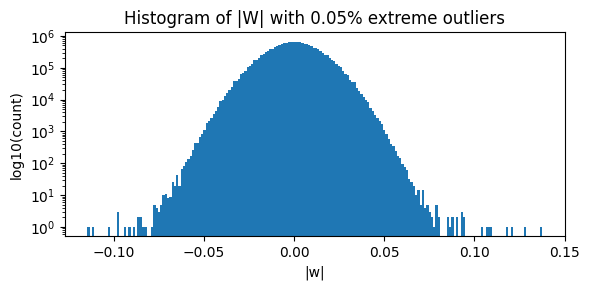

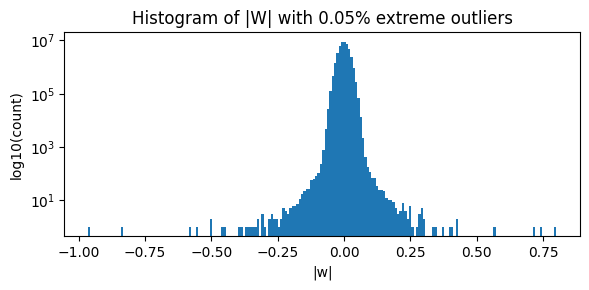

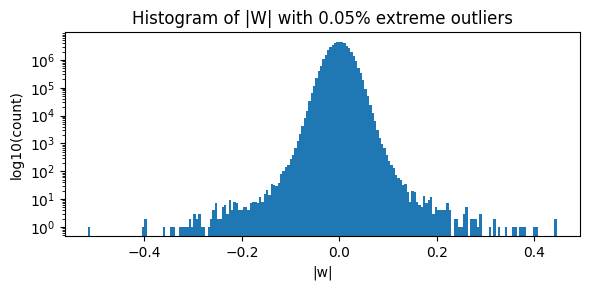

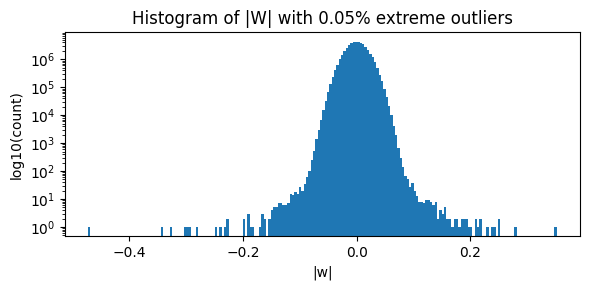

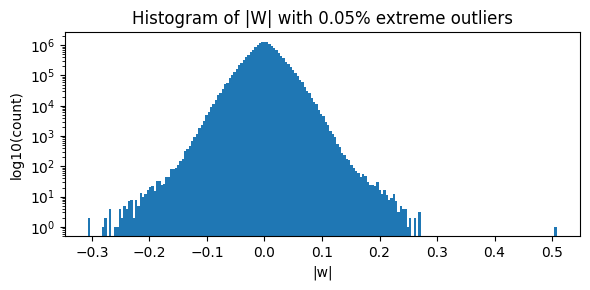

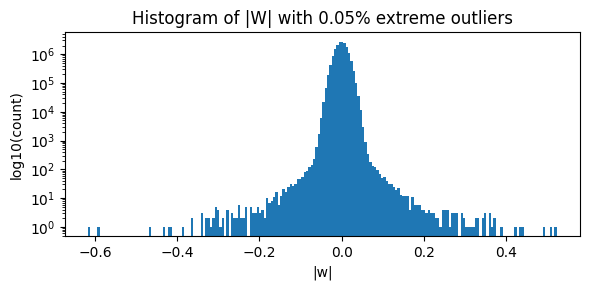

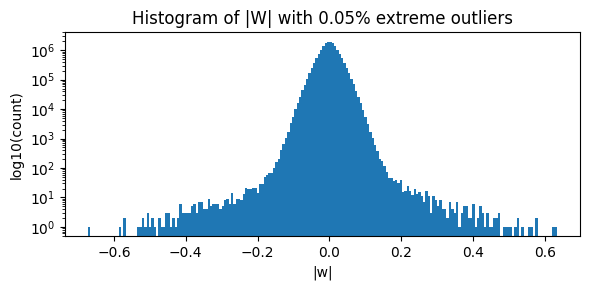

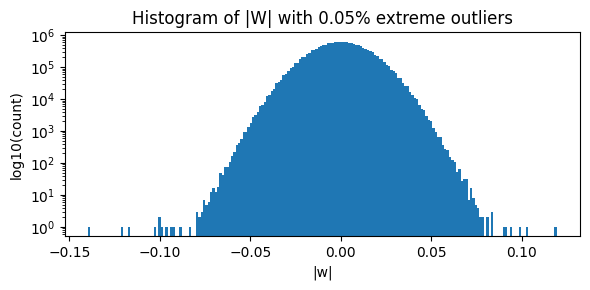

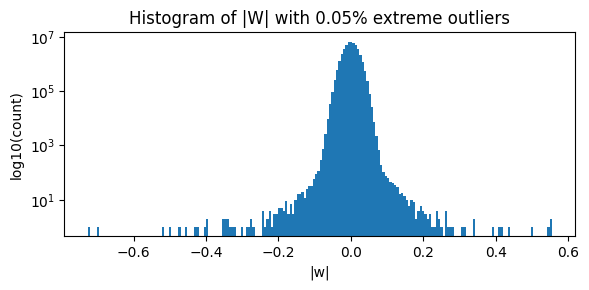

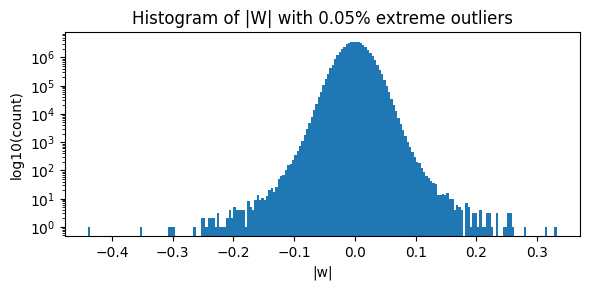

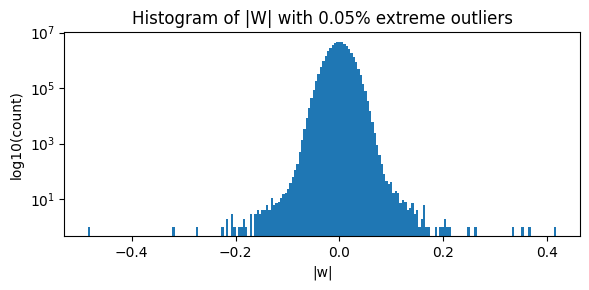

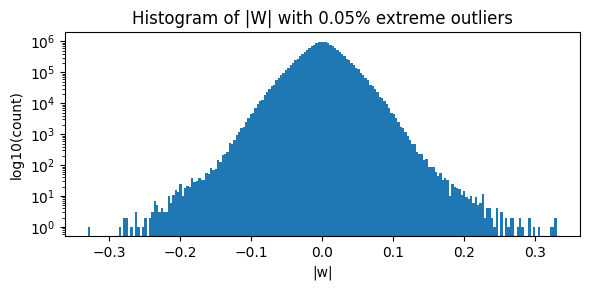

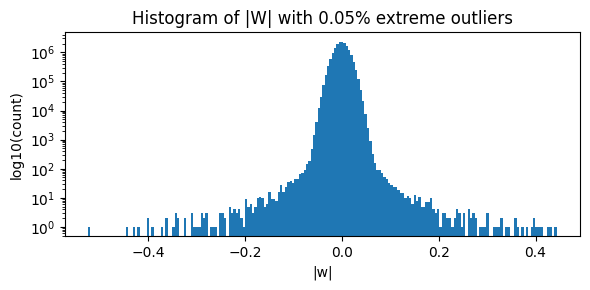

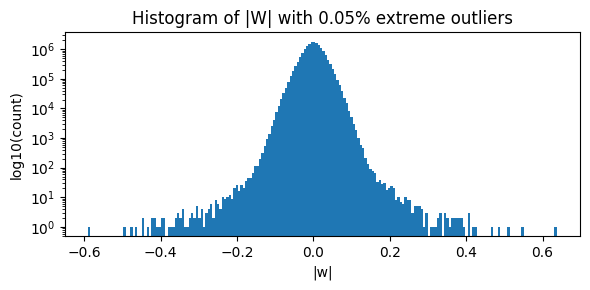

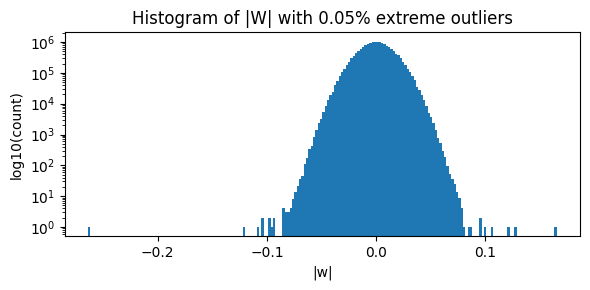

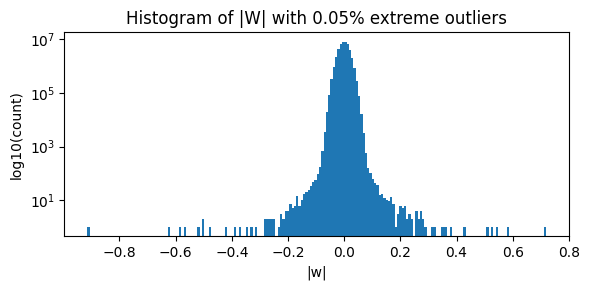

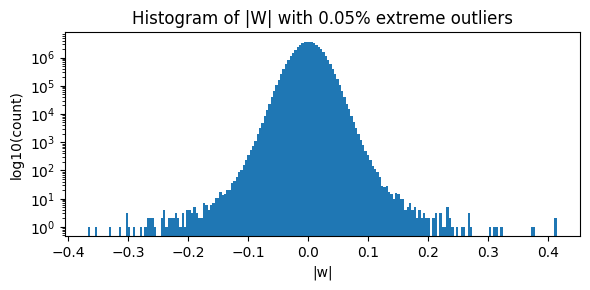

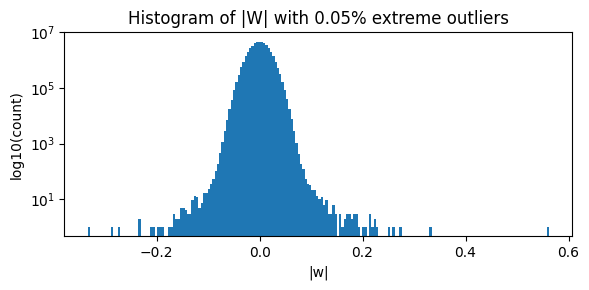

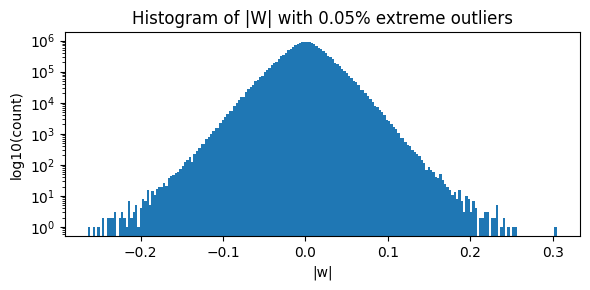

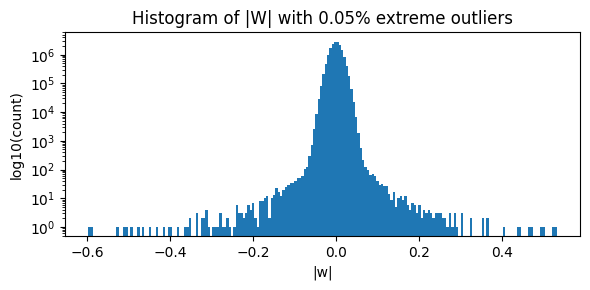

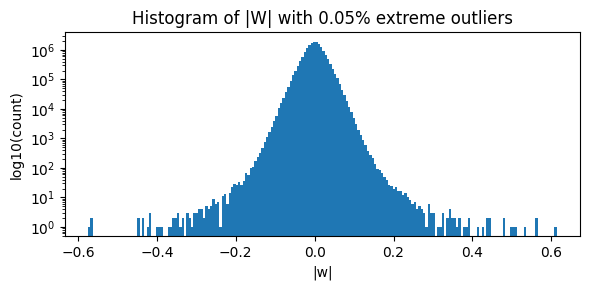

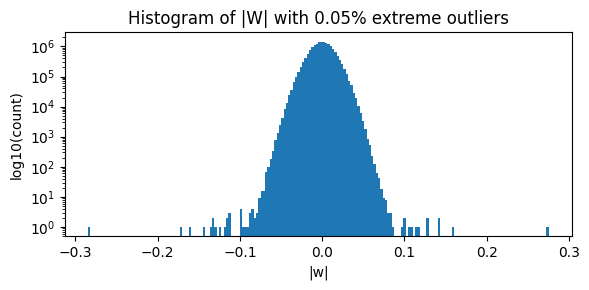

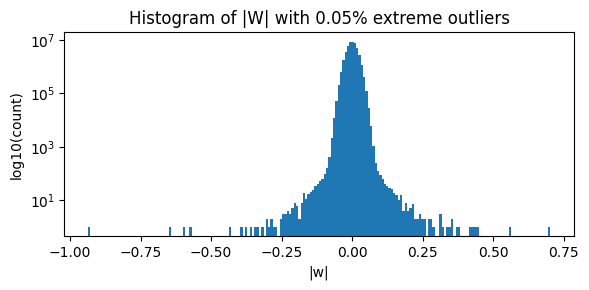

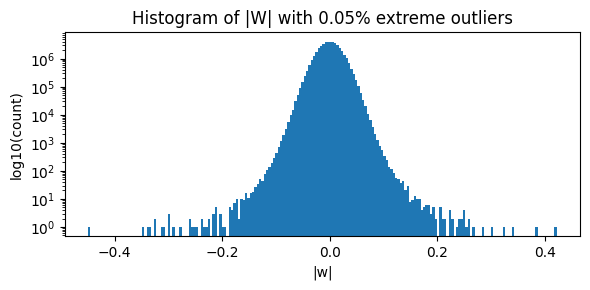

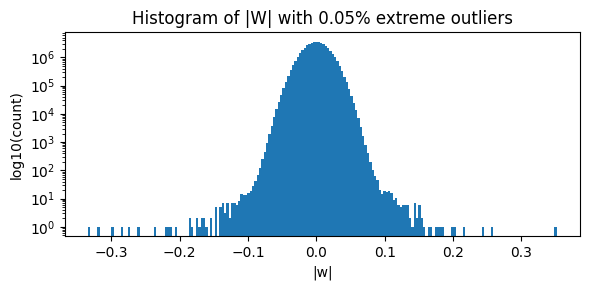

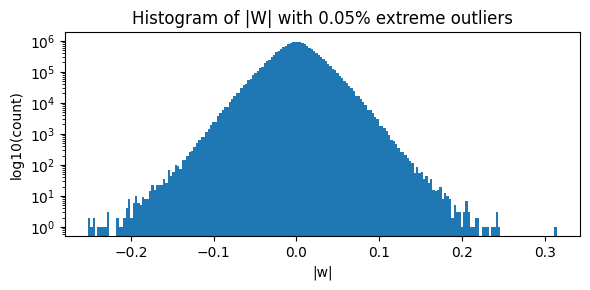

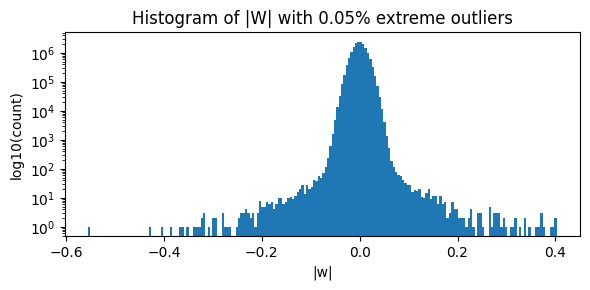

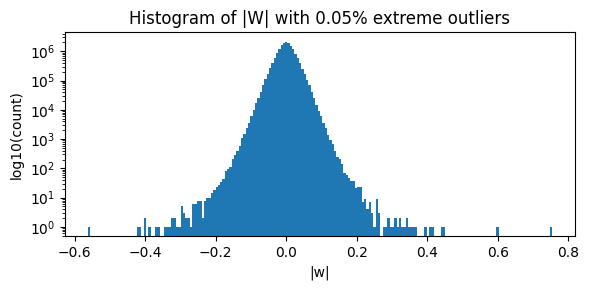

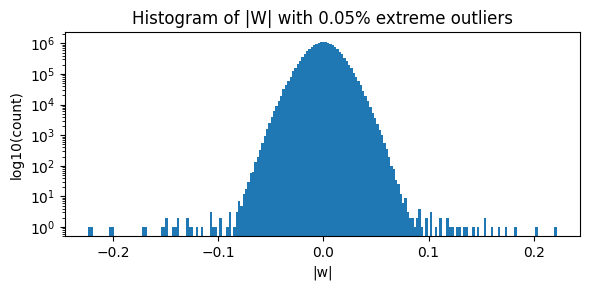

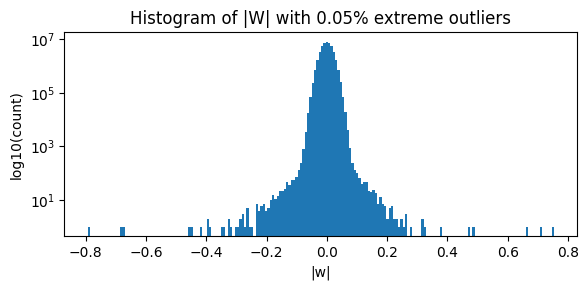

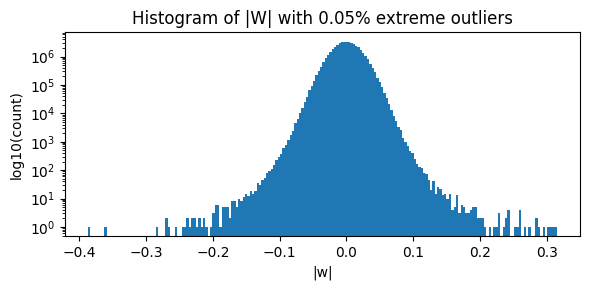

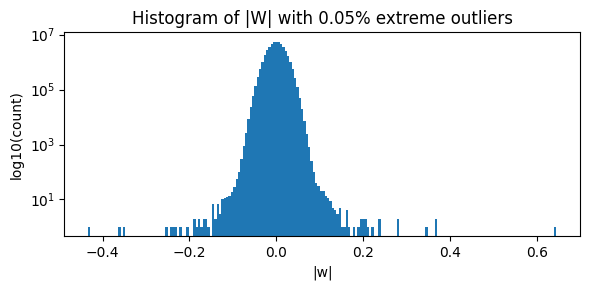

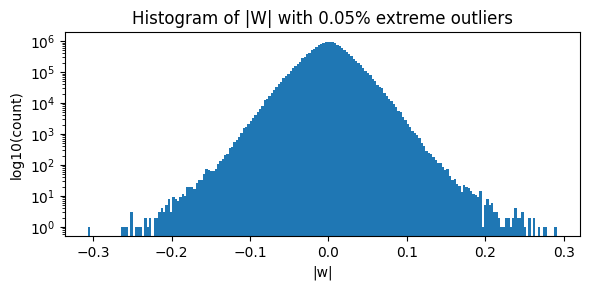

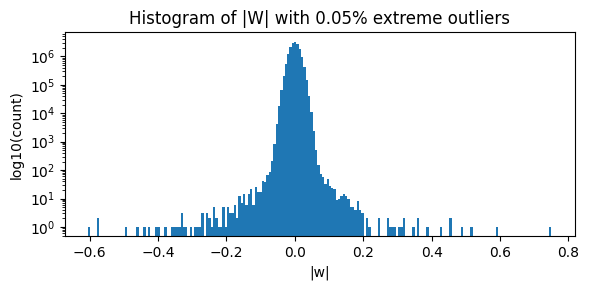

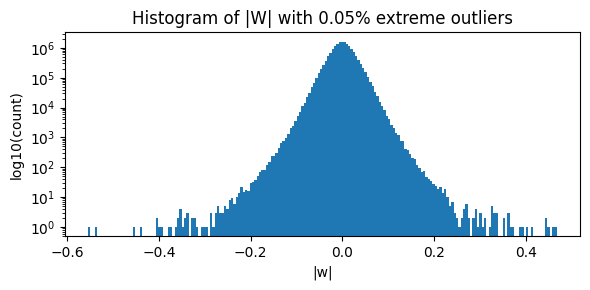

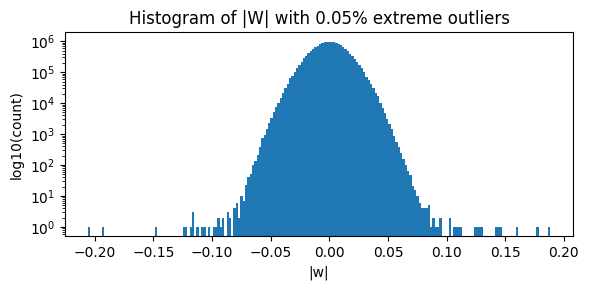

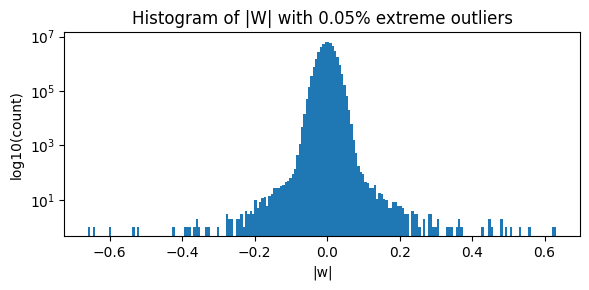

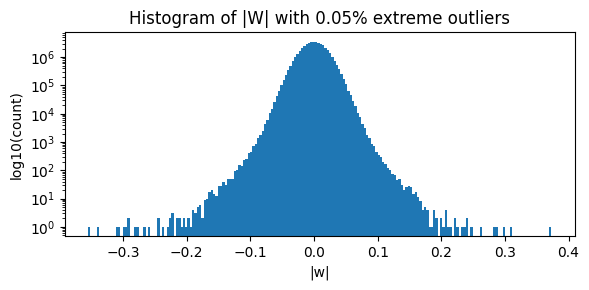

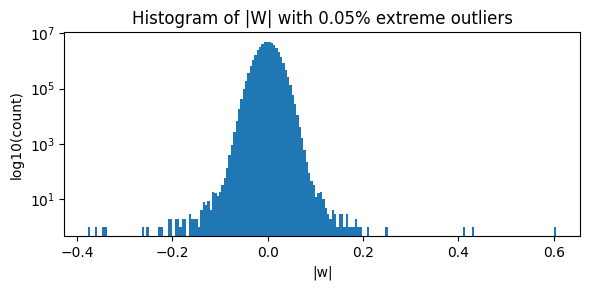

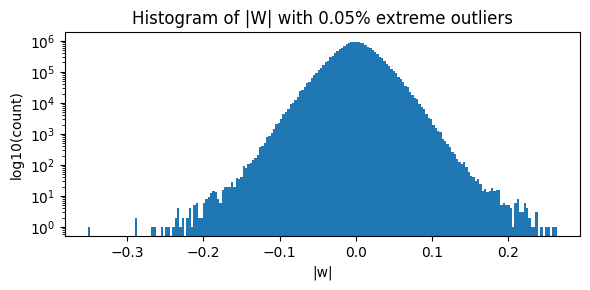

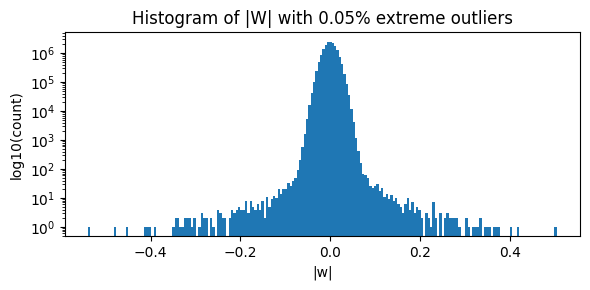

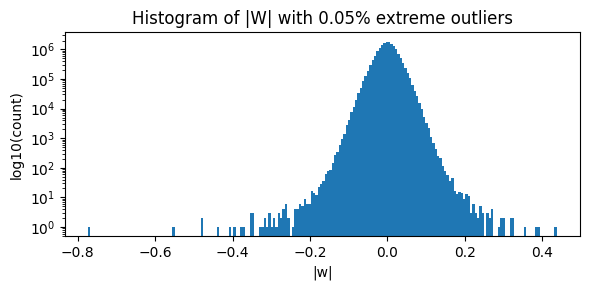

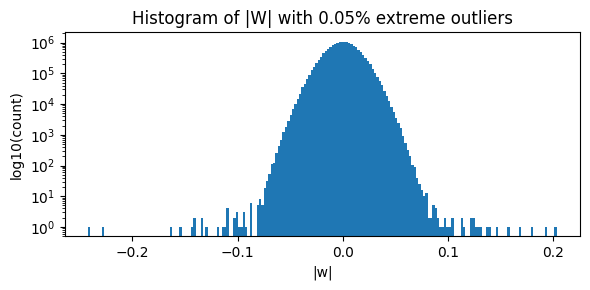

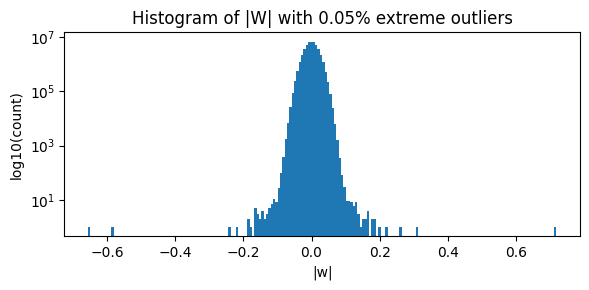

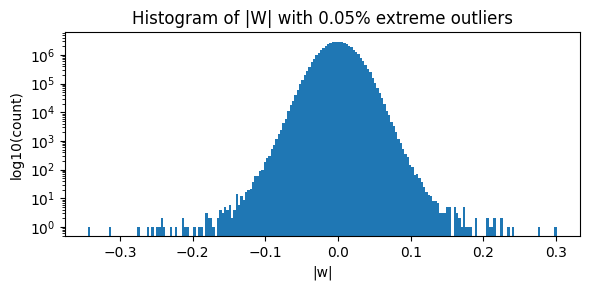

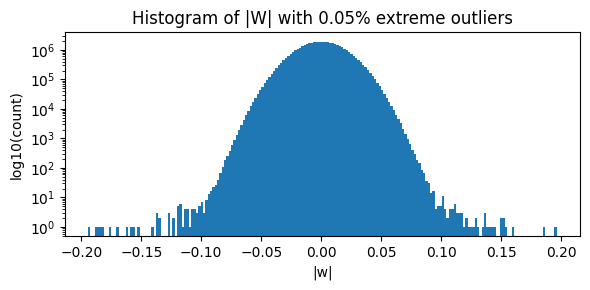

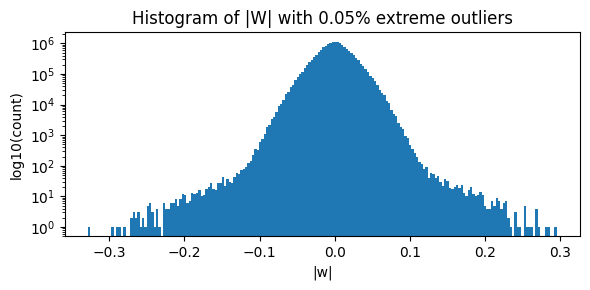

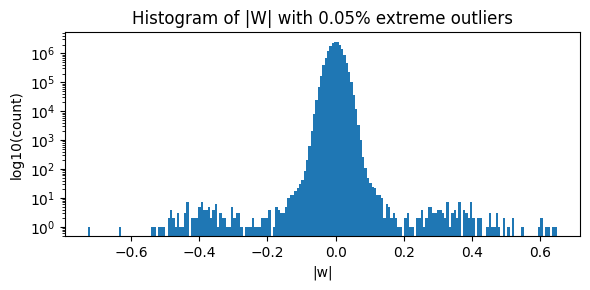

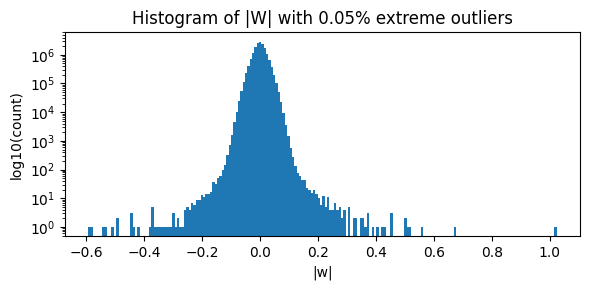

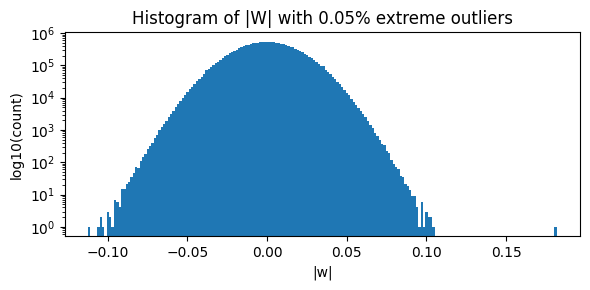

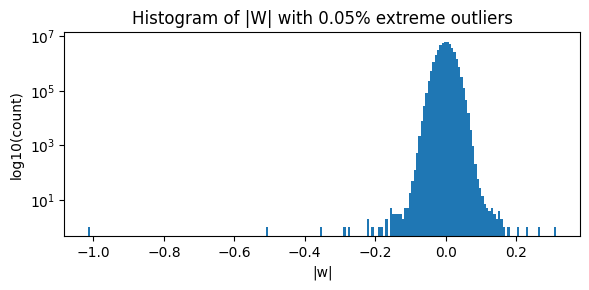

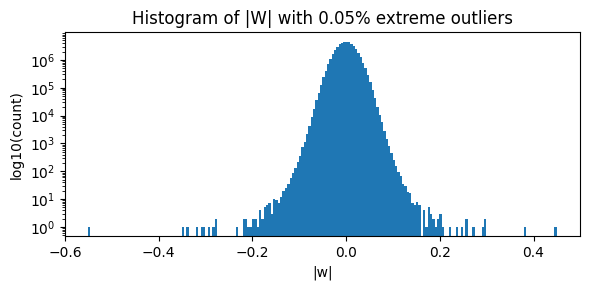

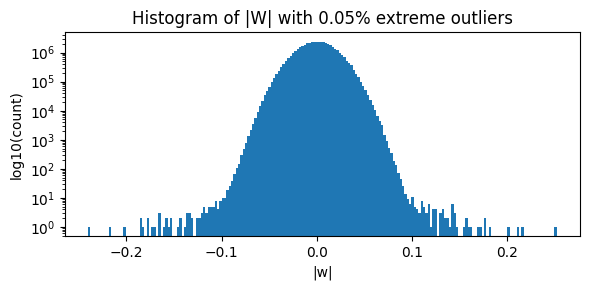

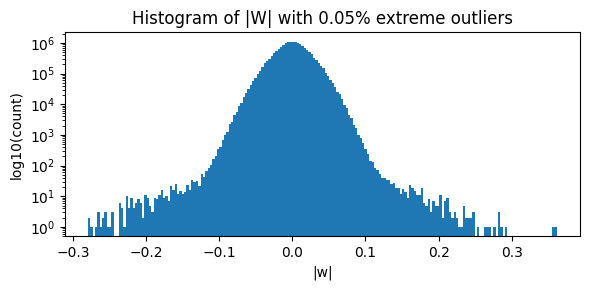

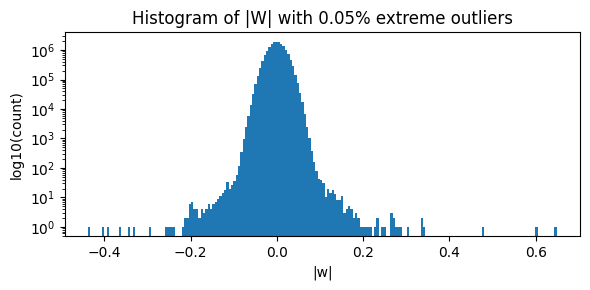

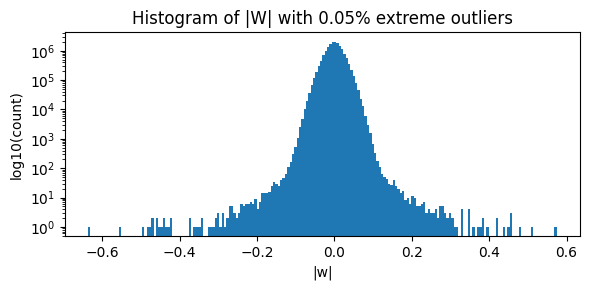

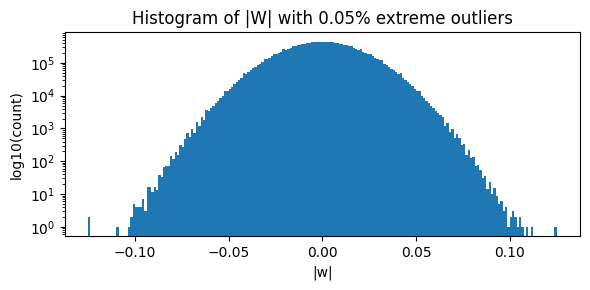

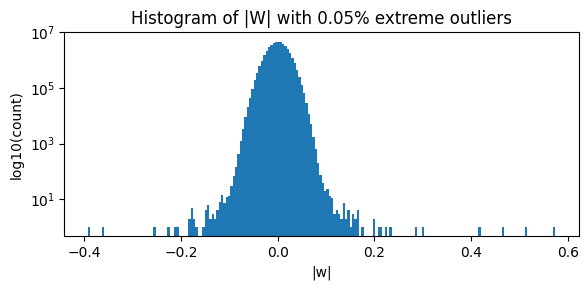

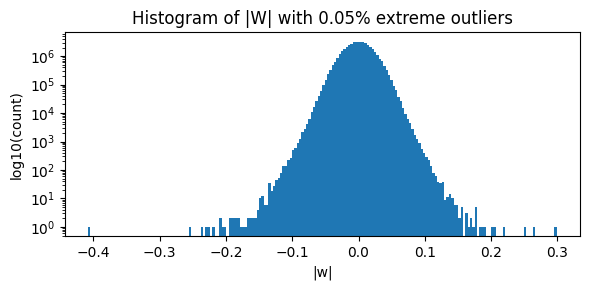

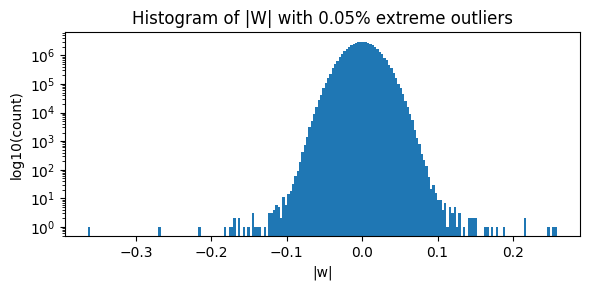

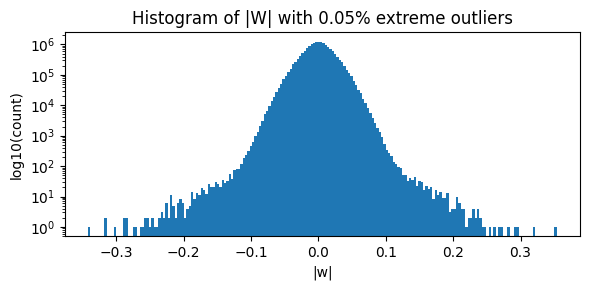

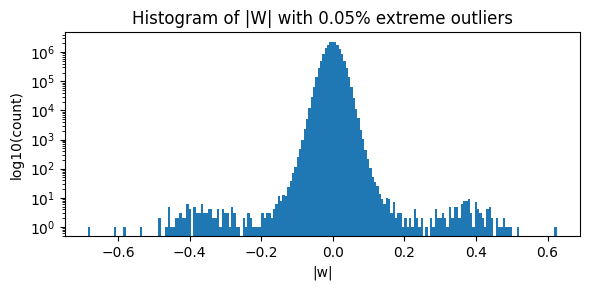

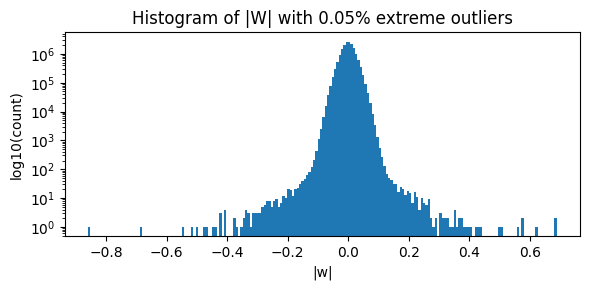

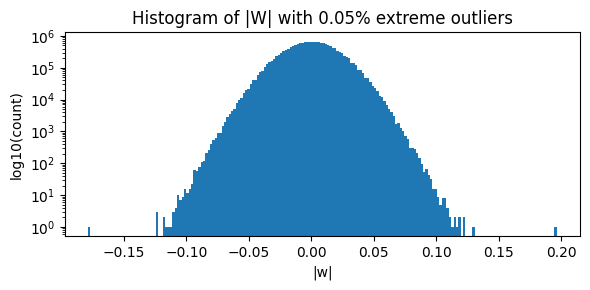

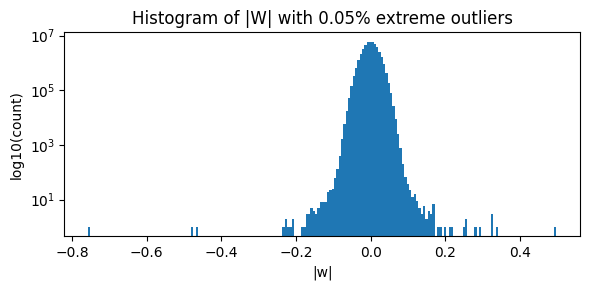

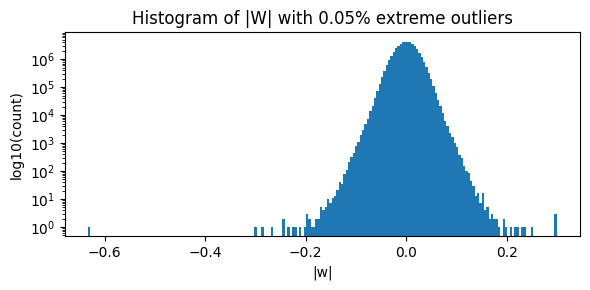

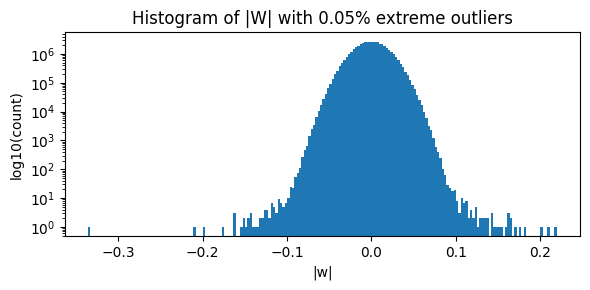

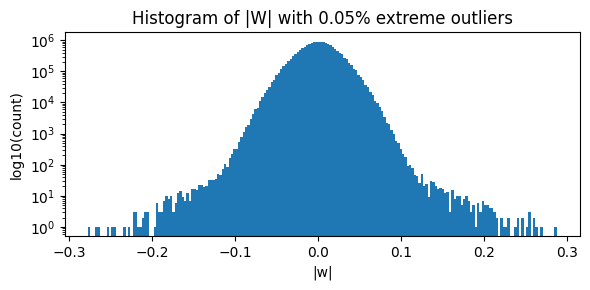

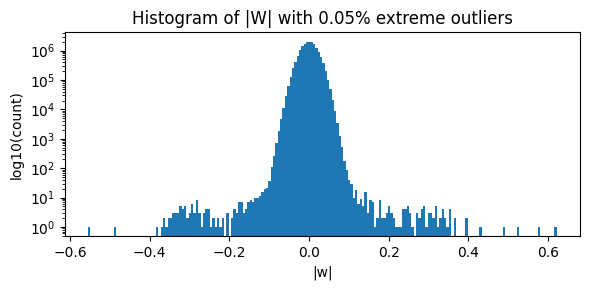

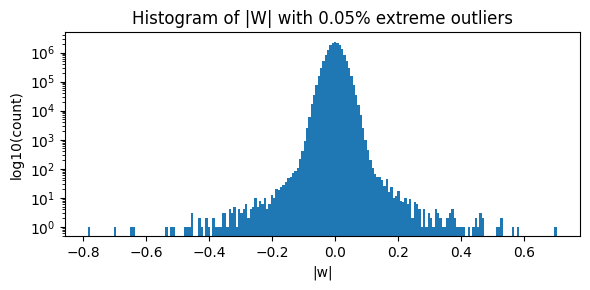

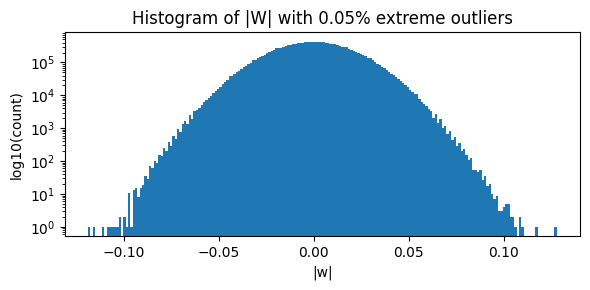

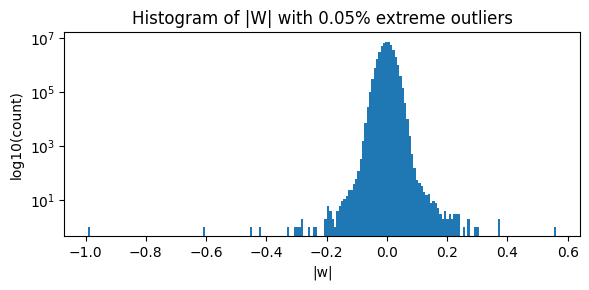

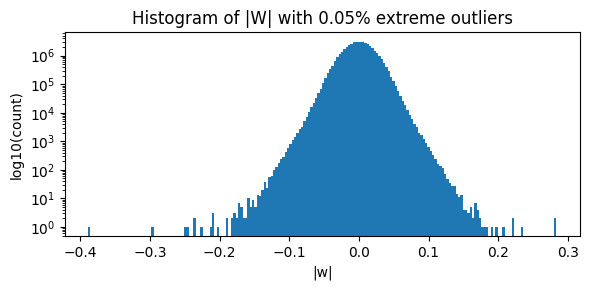

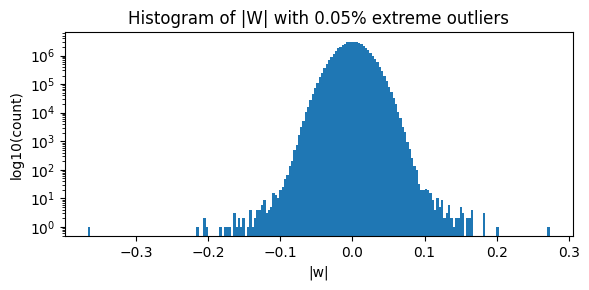

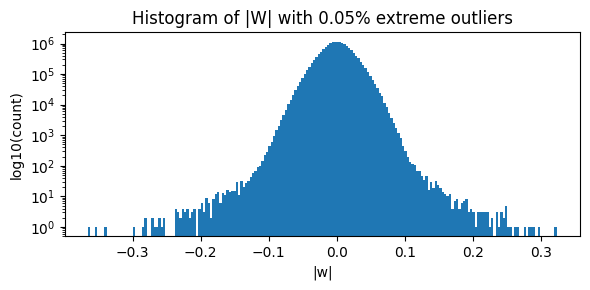

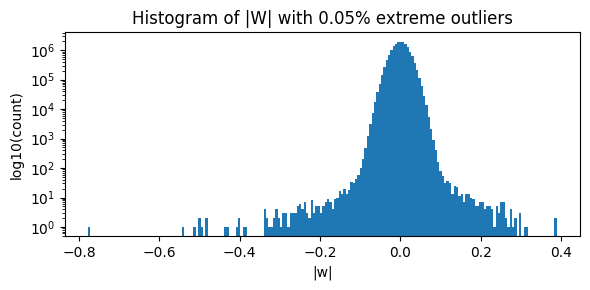

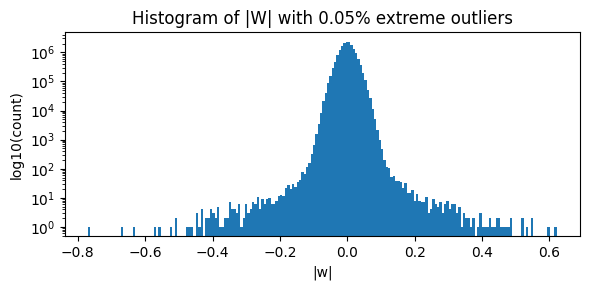

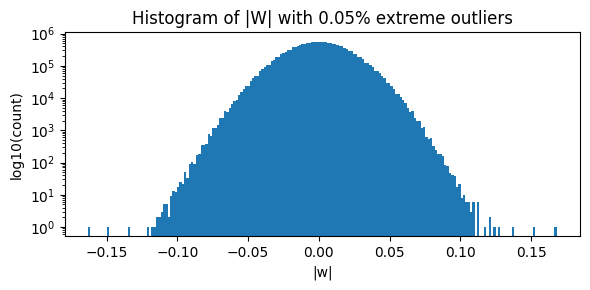

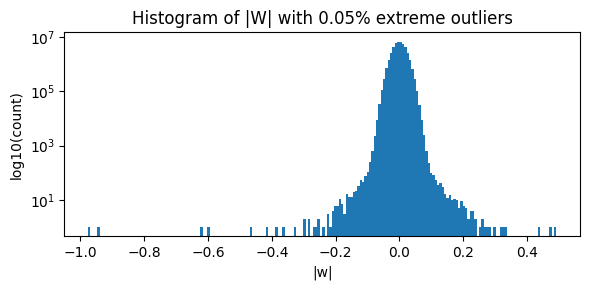

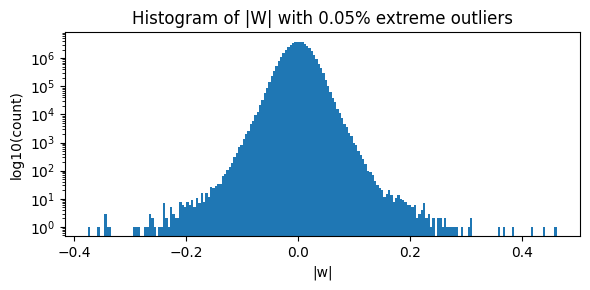

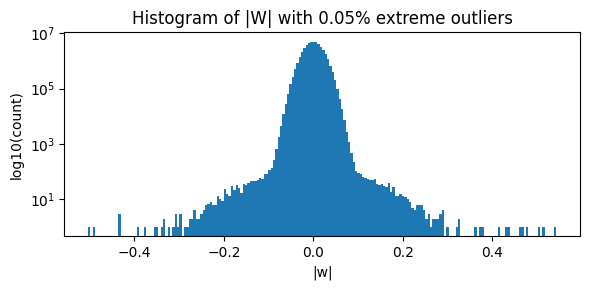

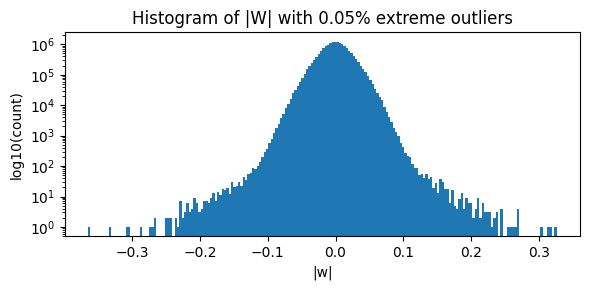

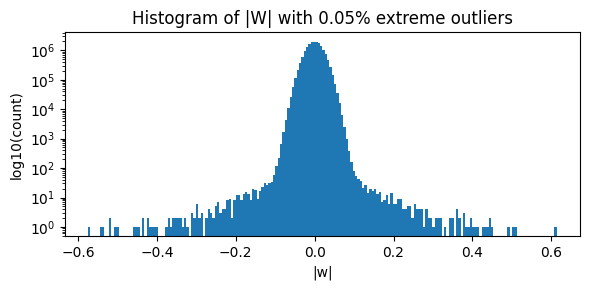

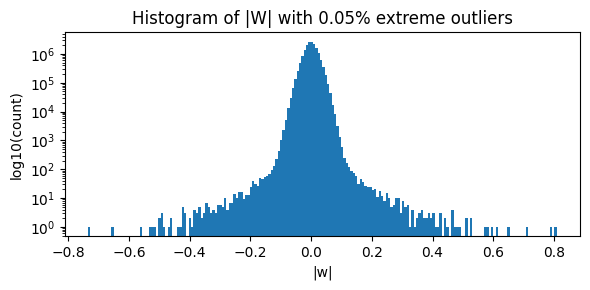

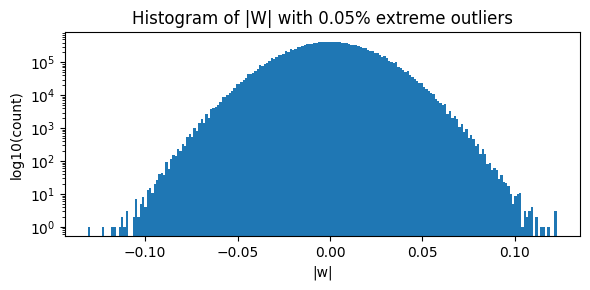

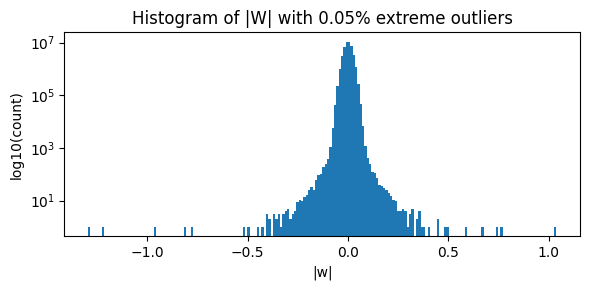

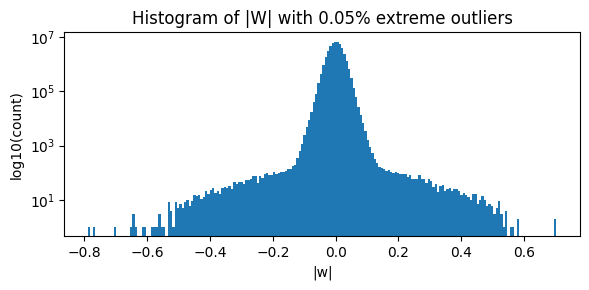

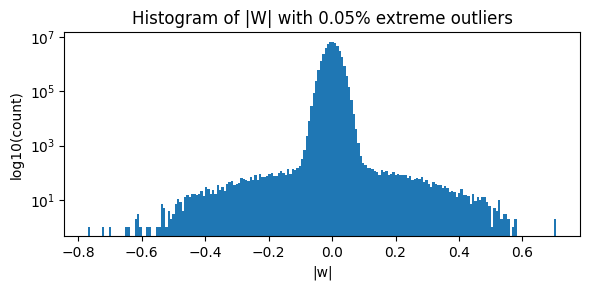

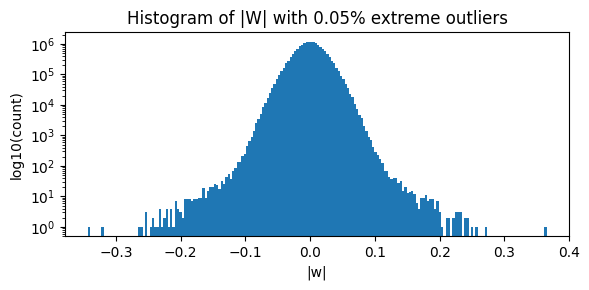

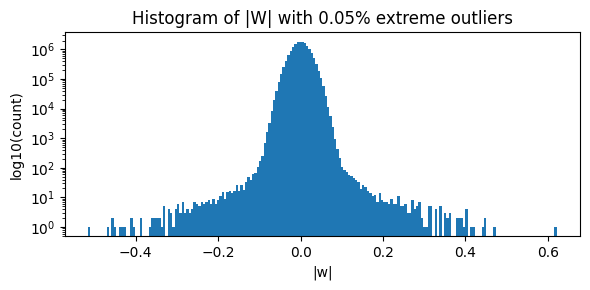

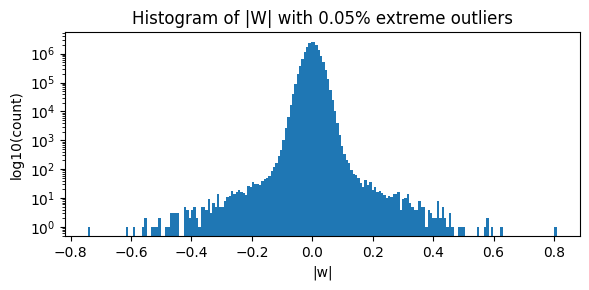

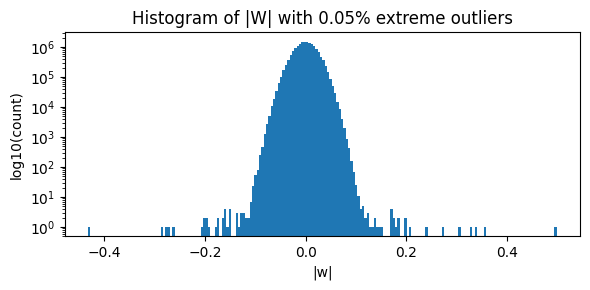

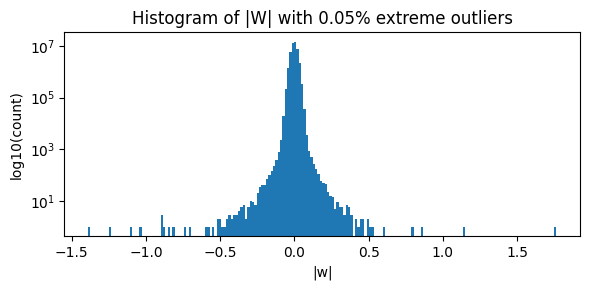

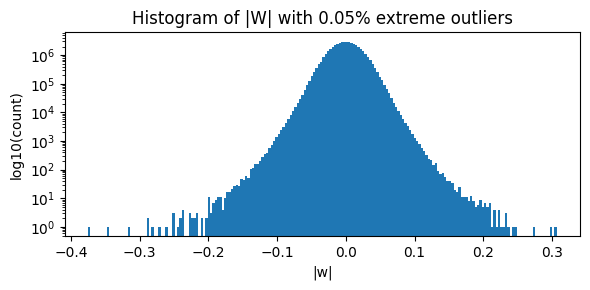

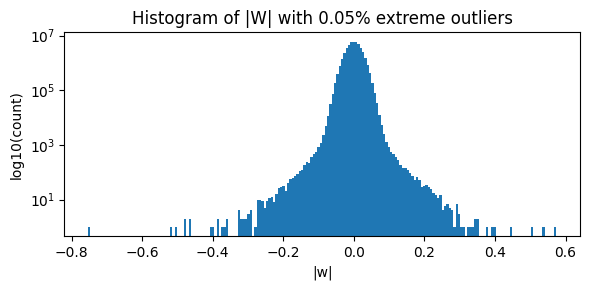

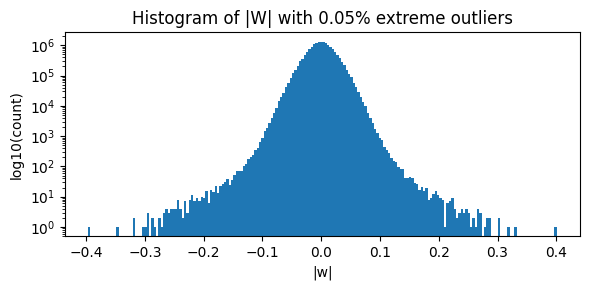

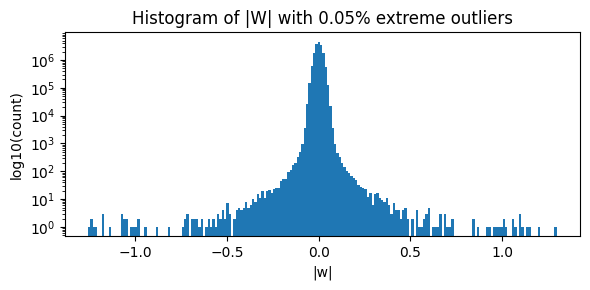

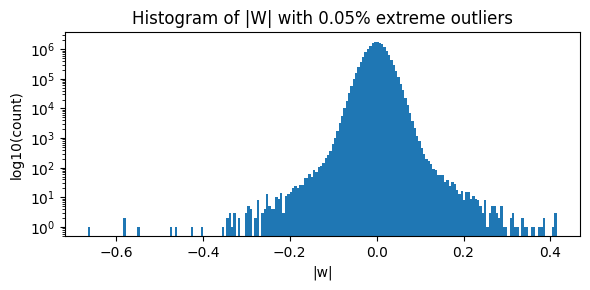

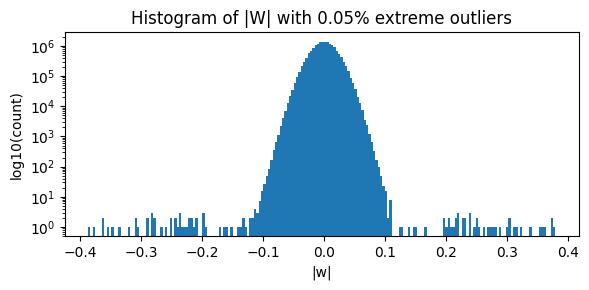

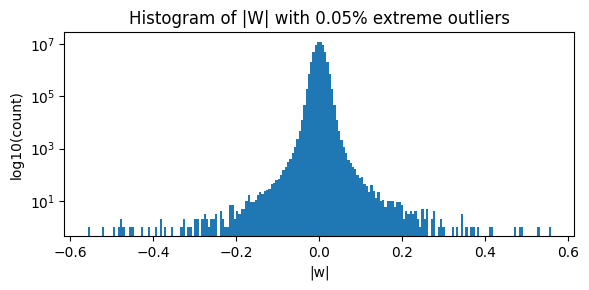

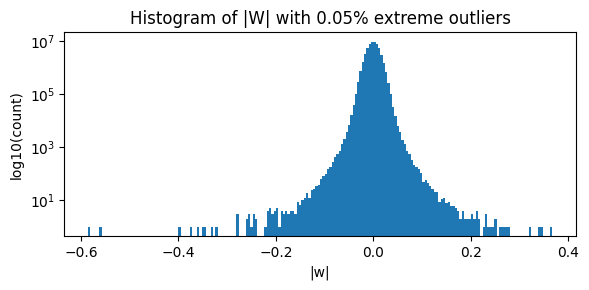

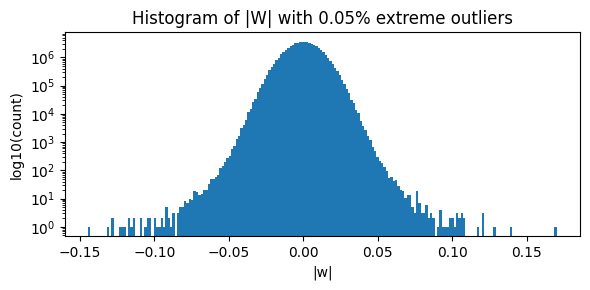

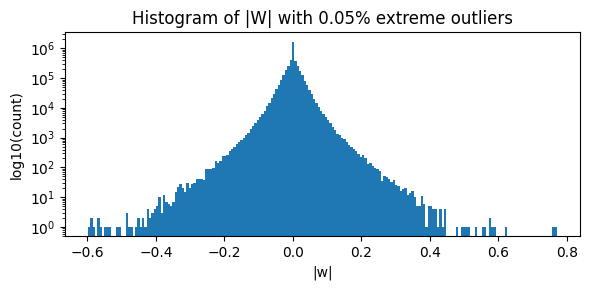

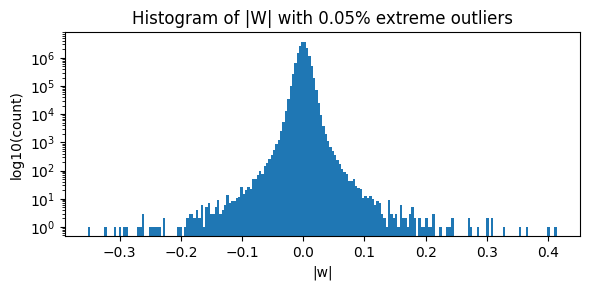

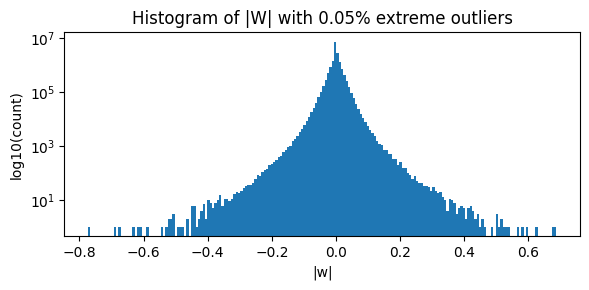

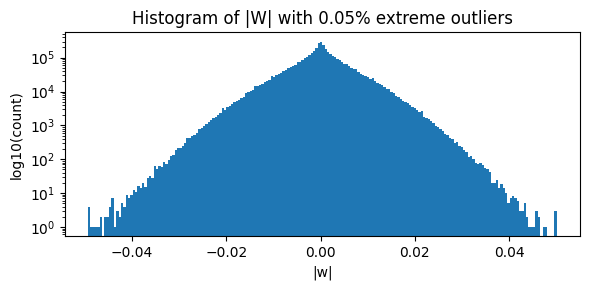

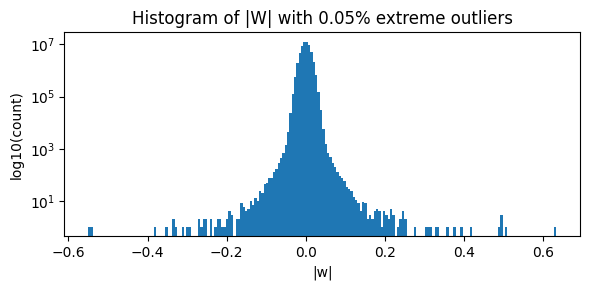

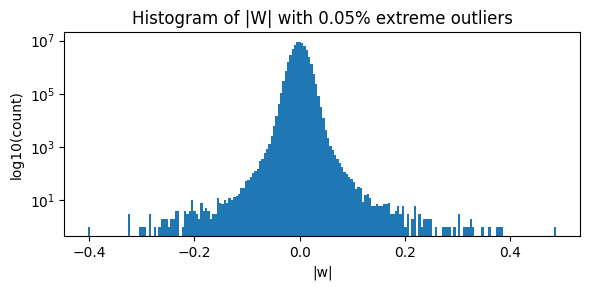

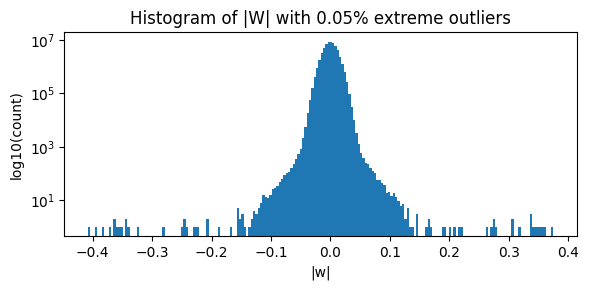

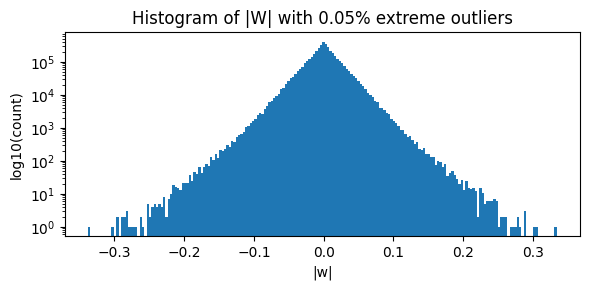

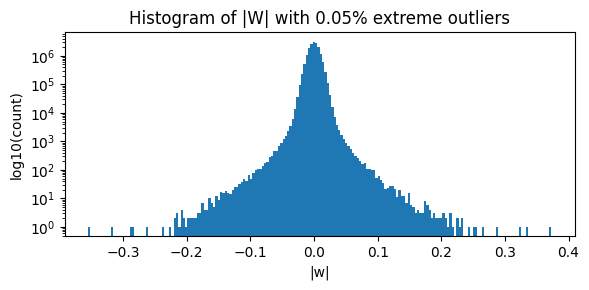

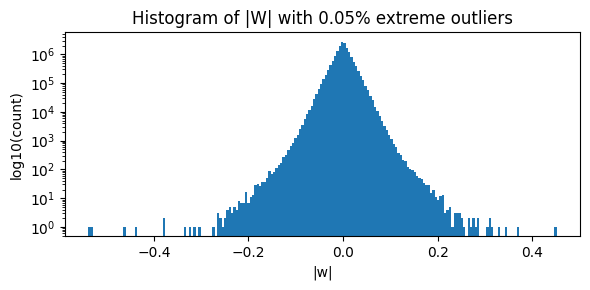

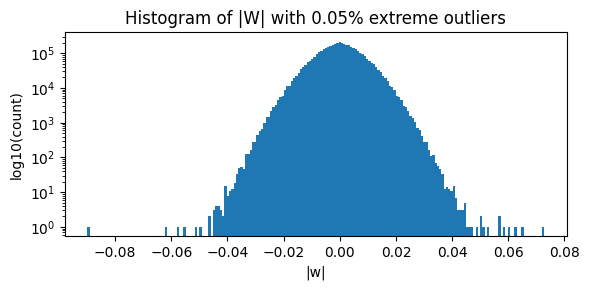

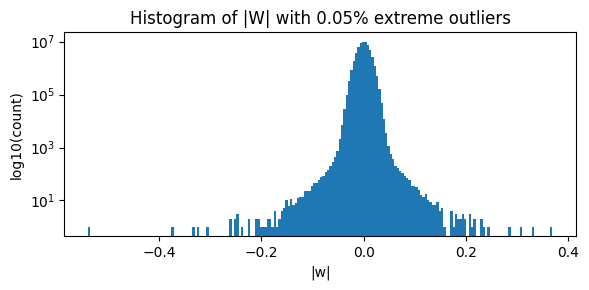

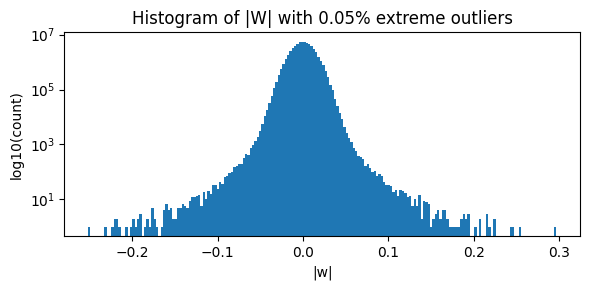

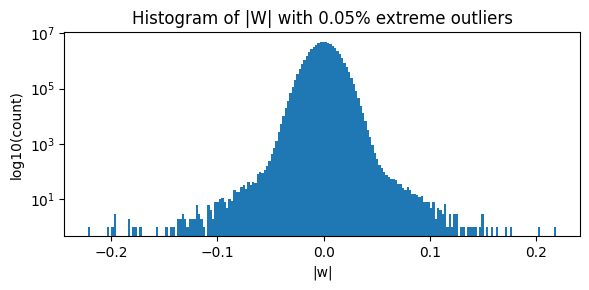

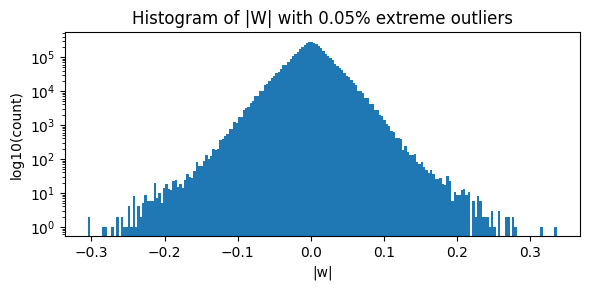

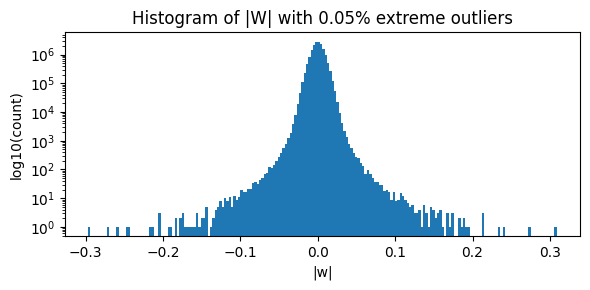

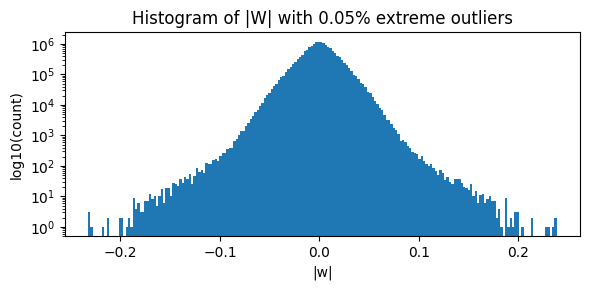

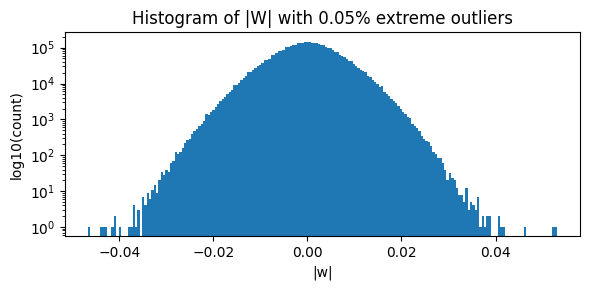

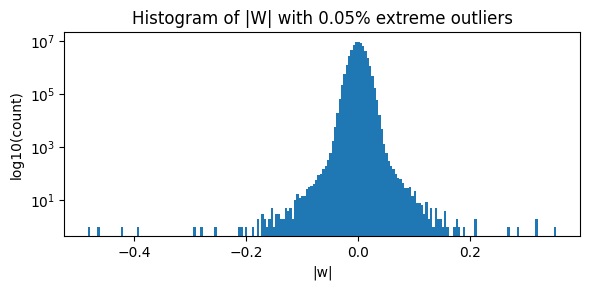

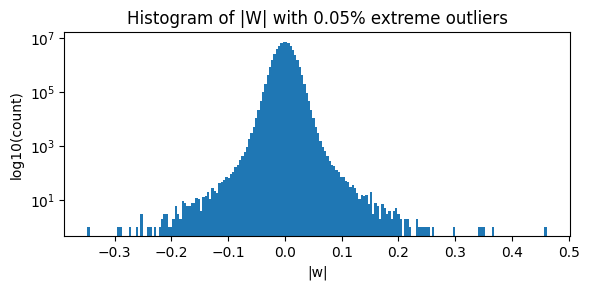

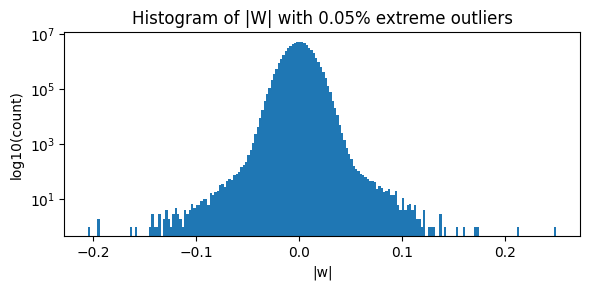

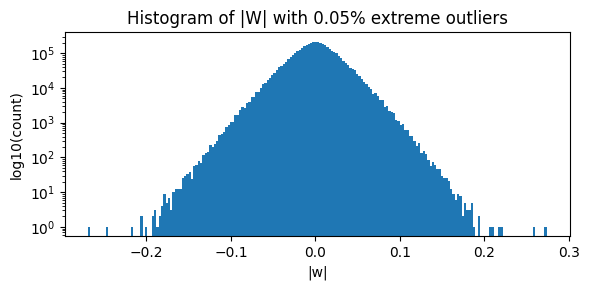

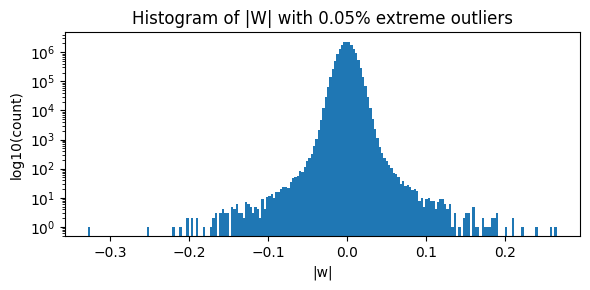

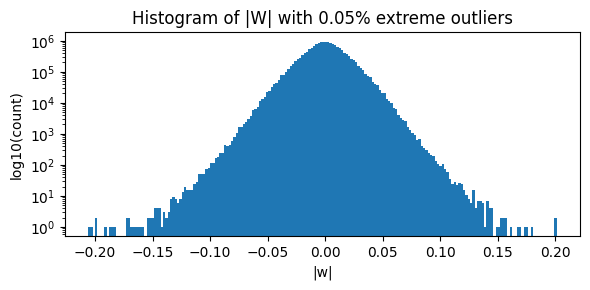

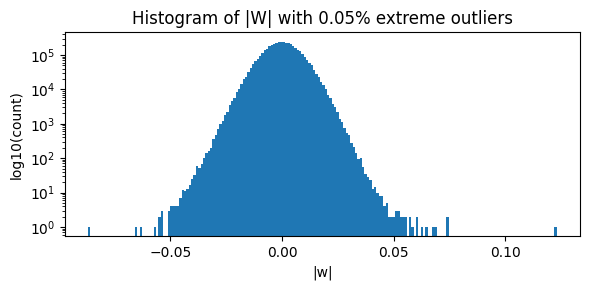

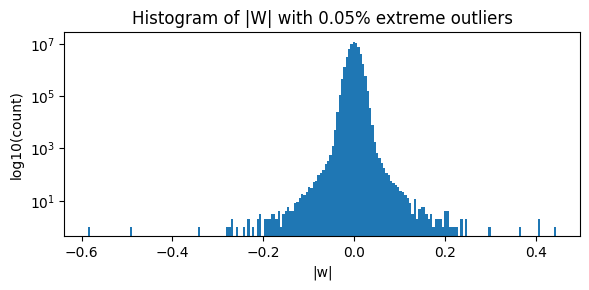

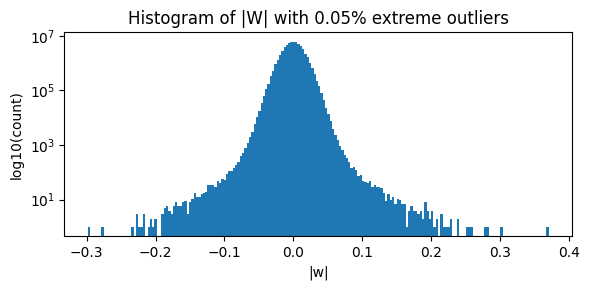

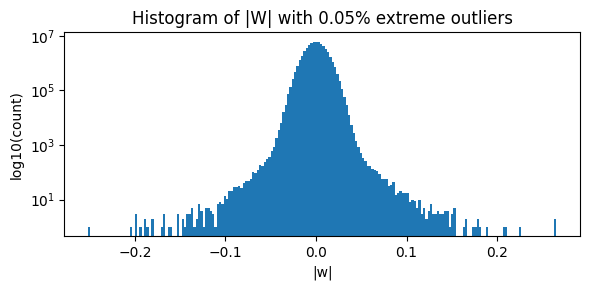

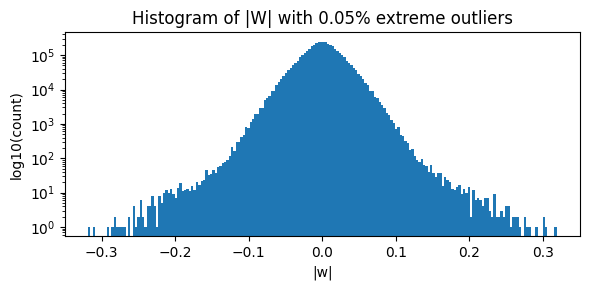

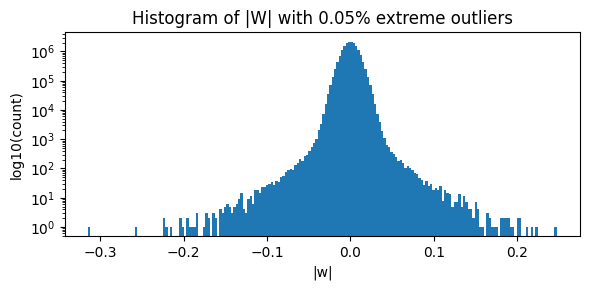

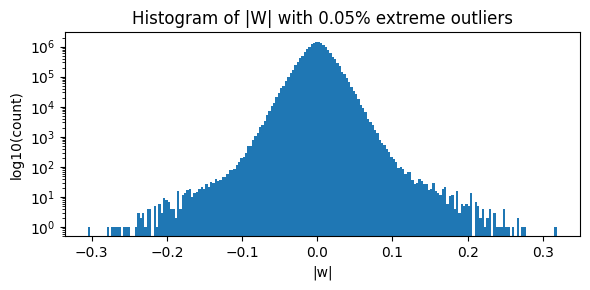

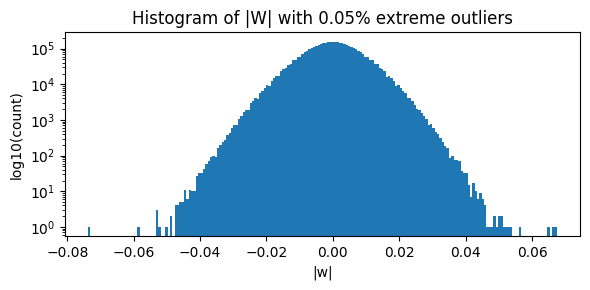

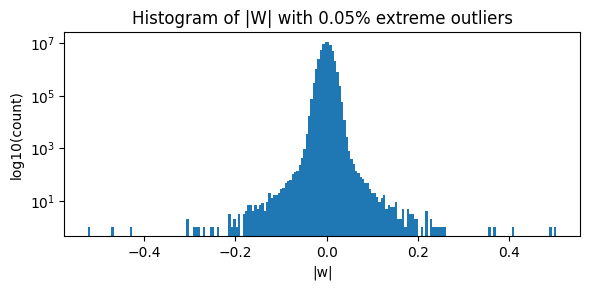

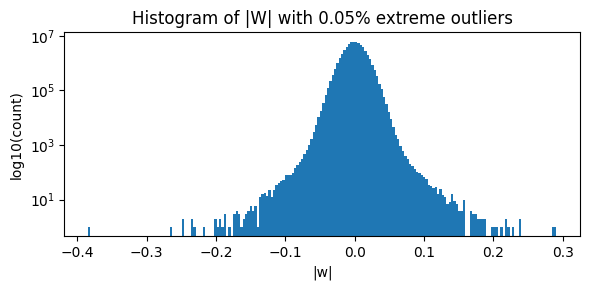

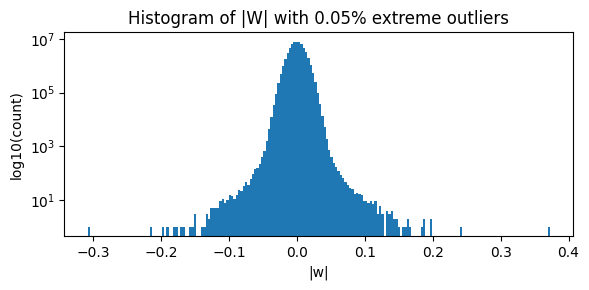

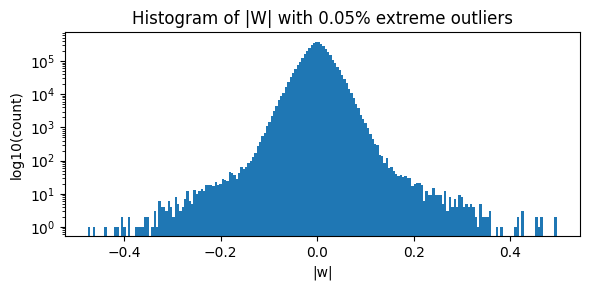

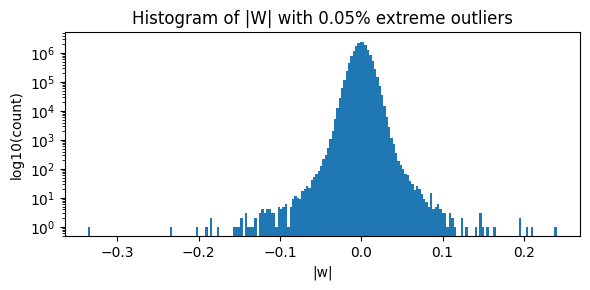

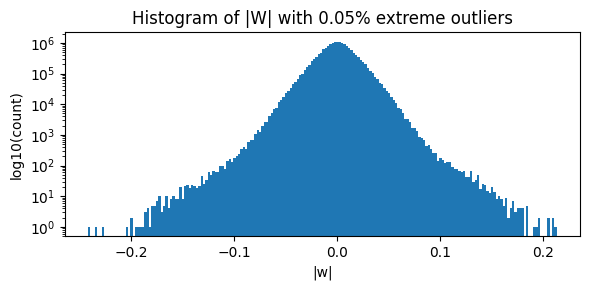

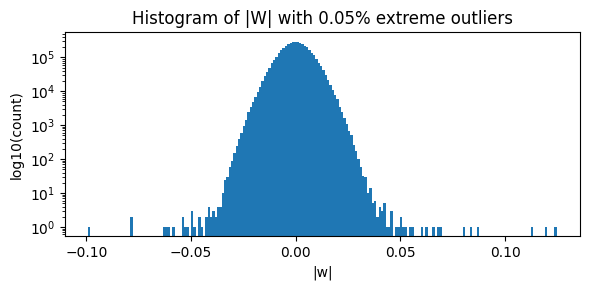

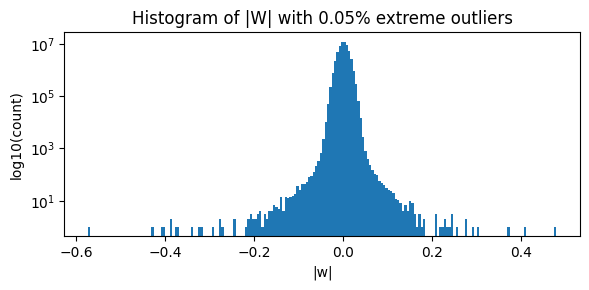

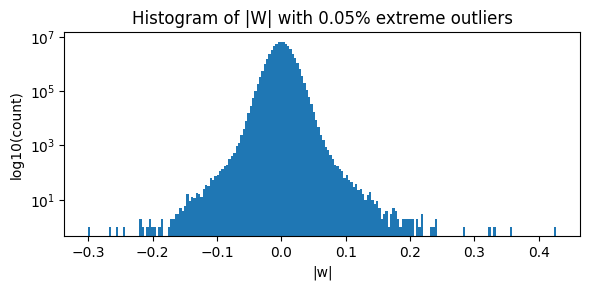

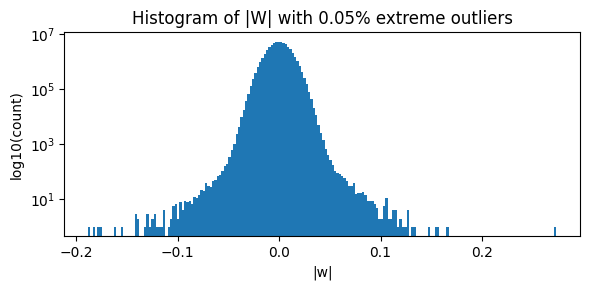

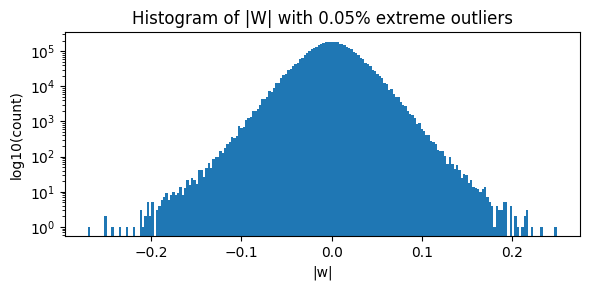

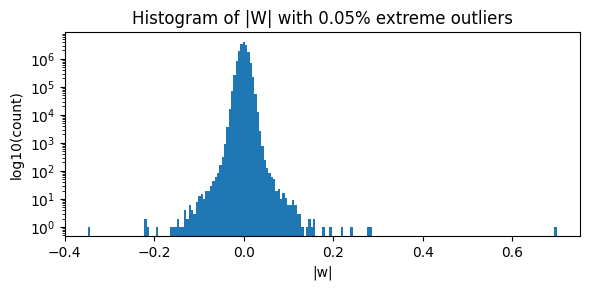

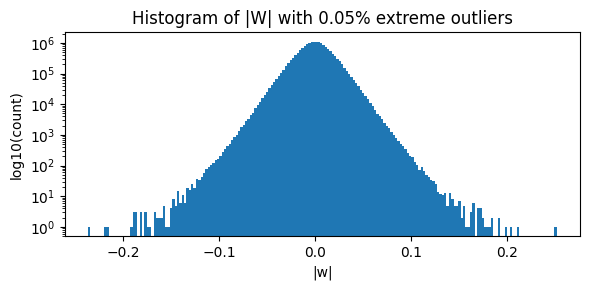

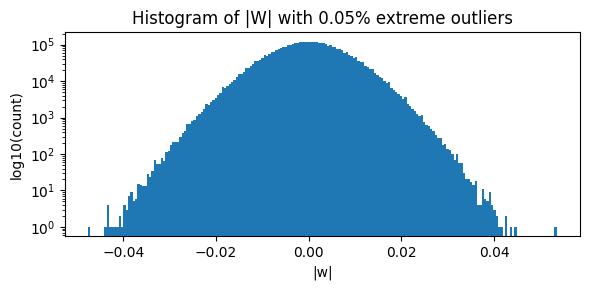

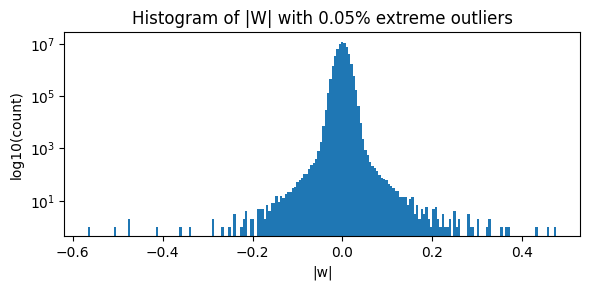

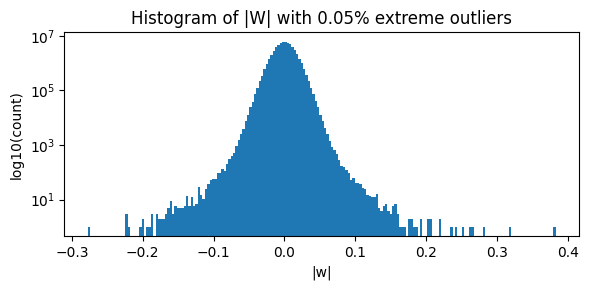

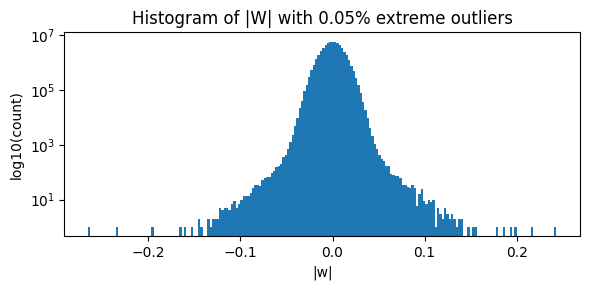

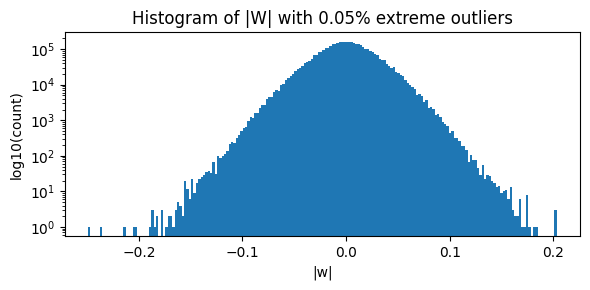

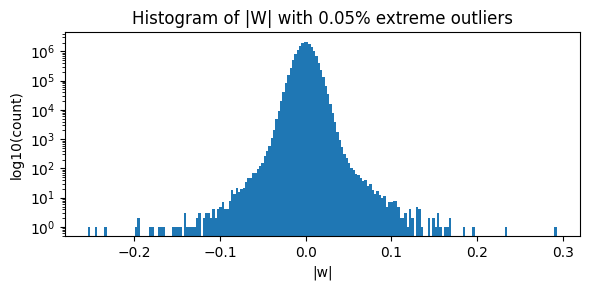

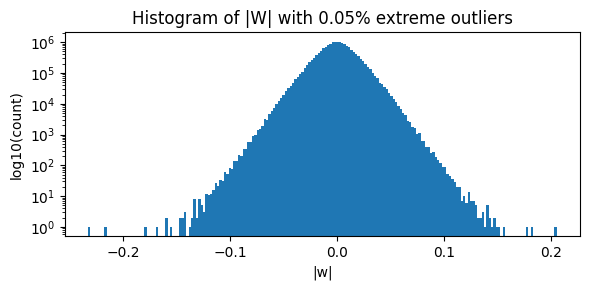

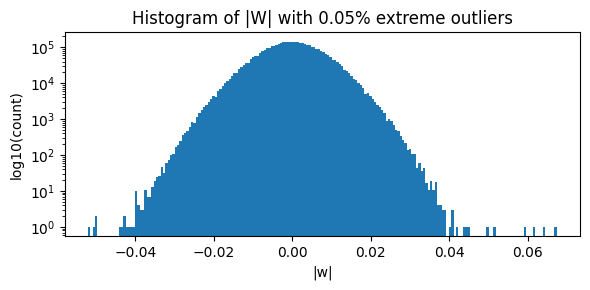

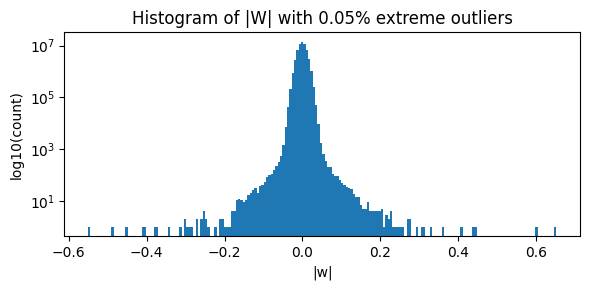

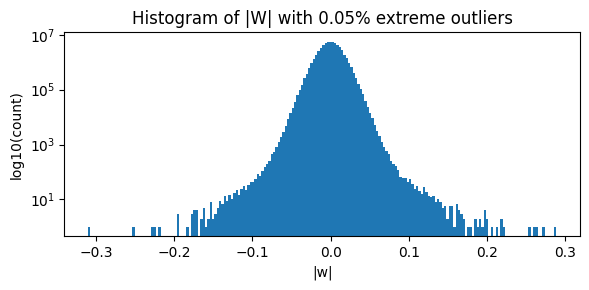

In [ ]:
# this is for visualization of the initial weight
ckpts = {"llama2":["/mnt/sdb/zhanglongteng/sdd/zhanglongteng/Llama-2-7b-chat-hf/model-00001-of-00002.safetensors", "/mnt/sdb/zhanglongteng/sdd/zhanglongteng/Llama-2-7b-chat-hf/model-00002-of-00002.safetensors"], "llama3":["/mnt/sdb/zhanglongteng/sdd/zhanglongteng/Meta-Llama-3-8B-Instruct/model-00001-of-00004.safetensors","/mnt/sdb/zhanglongteng/sdd/zhanglongteng/Meta-Llama-3-8B-Instruct/model-00002-of-00004.safetensors","/mnt/sdb/zhanglongteng/sdd/zhanglongteng/Meta-Llama-3-8B-Instruct/model-00003-of-00004.safetensors","/mnt/sdb/zhanglongteng/sdd/zhanglongteng/Meta-Llama-3-8B-Instruct/model-00004-of-00004.safetensors"]}

for model in ["llama2", "llama3"]:
    e1s = []
    e2s = []
    for ckpt in ckpts[model]:
        safetensors = load_file(ckpt)
        for key, value in safetensors.items():
            if "self_attn" in key or "mlp" in key:
                if len(value.shape) != 2:
                    continue
                # u_opt, t_opt, rho_opt, sigma_est = optimal_sparsity_from_weights(value, k=4, eps_tail=None, return_stats=True)
                # print(f"Estimated σ = {sigma_est:.4f}")
                # print(f"Optimal u* = {u_opt:.4f}")
                # print(f"Prune threshold t* = σ·u* = {t_opt:.4f}")
                # print(f"Optimal sparsity ρ* = {rho_opt*100:.3f}%")
                for sparse_ratio in [0.000001]:
                    e1, e2 = check_outlier_restore(value.to("cuda"), sparsity_ratio=sparse_ratio)
                    print(f"Relative error for {key}: {e1.item()} (with outliers), {e2.item()} (without outliers)")
                    e1s.append(e1)
                    e2s.append(e2)
    avg_diff = (sum(e1s) - sum(e2s)) / len(e1s)
    print(f"Average difference for {model}: {avg_diff.item()}")
    torch.cuda.empty_cache()


In [10]:
def phi(u):
    """Standard Gaussian PDF at u."""
    return math.exp(-0.5 * u*u) / math.sqrt(2*math.pi)

def Phi(u):
    """Standard Gaussian CDF at u."""
    return 0.5 * (1 + math.erf(u / math.sqrt(2)))

def find_optimal_u(L, tol=1e-7, max_u=10.0, eps_tail=None):
    """
    Solve for u>0 in
       Dg(u) = Do(u) * eps_tail(u)
    where
       Dg(u) = u^2 / (3 L^2)
       Do(u) = 2 [u*phi(u) + (1 - Phi(u))]
    If eps_tail is None, it solves Dg(u)=Do(u).
    """
    def Dg(u):
        return (u*u) / (3 * L * L)
    def Do(u):
        return 2 * (u * phi(u) + (1 - Phi(u)))
    def f(u):
        if eps_tail is None:
            return Dg(u) - Do(u)
        else:
            return Dg(u) - Do(u) * eps_tail(u)

    a, b = 1e-9, max_u
    fa, fb = f(a), f(b)
    if fa * fb > 0:
        raise RuntimeError(f"f(a)={fa:.3e}, f(b)={fb:.3e} same sign; increase max_u")

    # Bisection
    while b - a > tol:
        m = 0.5 * (a + b)
        fm = f(m)
        if fa * fm <= 0:
            b, fb = m, fm
        else:
            a, fa = m, fm
    return 0.5 * (a + b)

def optimal_sparsity_from_weights(W,
                                  k=4,
                                  eps_tail=None,
                                  return_stats=False):
    """
    Given a weight matrix W (torch.Tensor or np.ndarray):
      - estimates sigma = std(W)
      - solves for u* with k‐bit quantization (L=2^k−1 levels)
      - returns (u*, t*=sigma*u*, rho*=2[1-Phi(u*)])
    If eps_tail(u) is provided, it should be a function u-> [0,1] giving the
    fraction of tail‐energy *not* recovered by your rank‐r path.
    If return_stats=True, also returns the estimated sigma.
    """
    # 1) Convert to torch CPU float and estimate std
    if not isinstance(W, torch.Tensor):
        W = torch.tensor(W)
    W_cpu = W.detach().cpu().to(torch.float32)
    sigma = float(W_cpu.std(unbiased=True).item())

    # 2) Solve for u*
    L = 2**k - 1
    u_star = find_optimal_u(L, eps_tail=eps_tail)

    # 3) Compute threshold & sparsity ratio
    t_star = sigma * u_star
    rho_star = 2 * (1 - Phi(u_star))

    if return_stats:
        return u_star, t_star, rho_star, sigma
    else:
        return u_star, t_star, rho_star


In [ ]:
# deprecated
# this is for visualization of the pruned weight
ckpts = {"llama2":["/mnt/sdb/zhanglongteng/sdd/zhanglongteng/Llama-2-7b-chat-hf/model-00001-of-00002.safetensors", "/mnt/sdb/zhanglongteng/sdd/zhanglongteng/Llama-2-7b-chat-hf/model-00002-of-00002.safetensors"], "llama3":["/mnt/sdb/zhanglongteng/sdd/zhanglongteng/Meta-Llama-3-8B-Instruct/model-00001-of-00004.safetensors","/mnt/sdb/zhanglongteng/sdd/zhanglongteng/Meta-Llama-3-8B-Instruct/model-00002-of-00004.safetensors","/mnt/sdb/zhanglongteng/sdd/zhanglongteng/Meta-Llama-3-8B-Instruct/model-00003-of-00004.safetensors","/mnt/sdb/zhanglongteng/sdd/zhanglongteng/Meta-Llama-3-8B-Instruct/model-00004-of-00004.safetensors"]}

for model in ["llama2", "llama3"]:
    e1s = []
    e2s = []
    for ckpt in ckpts[model]:
        safetensors = load_file(ckpt)
        for key, value in safetensors.items():
            if "self_attn" in key or "mlp" in key:
                if len(value.shape) != 2:
                    continue
                e1, e2 = check_outlier_restore(value.to("cuda"))
                print(f"Relative error for {key}: {e1.item()} (with outliers), {e2.item()} (without outliers)")
                e1s.append(e1)
                e2s.append(e2)
    avg_diff = (sum(e1s) - sum(e2s)) / len(e1s)
    print(f"Average difference for {model}: {avg_diff.item()}")
    torch.cuda.empty_cache()


In [ ]:
def make_extreme_outlier_weight(
        rows:int = 4096,
        cols:int = 4096,
        pct_outlier: float = 0.0005,
        outlier_mag: float = 30.0,
        seed: int = 42
    ) -> torch.Tensor:
    torch.manual_seed(seed)

    W = torch.randn(rows, cols, dtype = torch.bfloat16, device="cuda")

    # randperm
    num_outliers = int(rows * cols * pct_outlier)
    flat_idx = torch.randperm(rows * cols)[:num_outliers]

    # = +-30
    W.view(-1)[flat_idx[:num_outliers // 2]]  =  outlier_mag
    W.view(-1)[flat_idx[num_outliers // 2:]] = -outlier_mag

    return W

check_outlier_restore(make_extreme_outlier_weight())